### <span style="color:red">IMPORTANT: Only modify cells which have the following comment:</span>
```python
# Modify this cell
```
##### <span style="color:red">Do not add any new cells when you submit the homework. Only use the already provided python packages.</span>

## Analysis of stock prices using PCA / Notebook 1

In this take-home final you are to analyze the daily changes in stock prices using PCA and to mesure the dimension of stock sequences.

We Start by downloading data and pre-processing it to make it ready for analysis using Spark.

In [1]:
import sys,os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import math
import pandas as pd
from glob import glob
import pickle


### Stock Info
The Pickle file `Tickers.pkl` contains information about the stocks in the SP500.

* `TickerInfo` - a pandas table that stores the name, sector, and sector ID for 505 stocks
* `Tickers` - A list of the stocks that we are going to analyze (each student should eliminate a few of these stocks before doing their analysis)


In [2]:
D=pickle.load(open('Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
Tickers=D['Tickers']
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}

In [3]:
TickerInfo.head()

Ticker                 Name                  Sector SECTOR_ID
0    MMM        3M|3M Company             Industrials      INDS
1    ABT  Abbott Laboratories             Health Care        HC
2   ABBV          AbbVie Inc.             Health Care        HC
3    ACN        Accenture plc  Information Technology        IT
4   ATVI  Activision Blizzard  Information Technology        IT

### Differences between the stocks lists
In the following you will work with three different sets of stocks:

1. The stocks listed in `TickerInfo`
2. The stocks listed in `Tickers`
3. The stock files that you will download from S3.

* The stocks you will analyze are those in `Tickers` less the one that you were instructed to remove.
* The Files you will download contain all of the stocks in `Tickers` plus a few stocks that are skipped because they are outliers.
* The Stocks in `TickerInfo` include most of the stocks in `Tickers`, but there are a few missing. When we will represent each stock with its `SECTOR_ID` these stocks will be represented by their Ticker.

In [4]:
len(Tickers),len(TickerInfo)

(481, 505)

### Stock and sector information
`TickerInfo` is a pandas table containing, for each Ticker, the company name, the sector, and a sector ID. There are 11 sectors. Some, such as `Consumer Discretionary` and `Information Technology` include many stocks while others, such as `Telecommunication Services` include very few.

In [5]:
from collections import Counter
L=Counter(TickerInfo['Sector']).items()
print 'Sector ID\t\tSector Name\tNo. of Stocks'
print '=========\t\t===========\t============='
for l in L:
    print '%s\t%30s\t%d'%(Sectors[l[0]],l[0],l[1])

Sector ID		Sector Name	No. of Stocks
=========		===========	=============
INDS	                   Industrials	66
TS	    Telecommunication Services	4
CD	        Consumer Discretionary	84
UTIL	                     Utilities	28
CS	              Consumer Staples	37
HC	                   Health Care	60
MAT	                     Materials	25
IT	        Information Technology	70
RE	                   Real Estate	31
EN	                        Energy	34
FIN	                    Financials	66


### Download Data
The data is a directory with .csv files, one for each stock. This directory has been tarred and uploaded to 
S3, at:

https://mas-dse-open.s3.amazonaws.com/spdata_csv.tgz

**Download and untar** the file. This creates a directory called **spdata_csv**

## Read Data and create a single table

Your task in this notebook is to read the stock-information `.csv` files, extract from them the column 
`Adj. Open` and combine them into a single `.csv` file containing all of the information that is relevant for later analysis.

Below we suggest a particular sequence of steps, you can either follow these steps, or do this in your own way.  The end result should be a file called `SP500.csv` which stores the information described below.

### Convert files into pandas dataframes

In this step you read all of the relevant information into a large dictionary we call `Tables`.

The key to this dictionary is the stocks "ticker" which corresponds to the file name excluding the `.csv` extension.

You should read in all of the files in the directory `spdata_csv` other than:

* Files for tickers that are not in the list `Tickers`.
* Files for tickers that were listed in the email you got for this final.

In the email you got about this final, there is a list of tickers that you should omit from your analysis.

# Task 1:
Create a function **getTables** which returns the dictionary *Tables* as described above. 

######  <span style="color:blue">Code:</span>
```python
Tables = getTables()
print type(Tables)
print len(Tables)
Tables['IBM'].head()
```

######  <span style="color:magenta">Output:</span>
```python
dict
476

```
<p><img alt="" src="figs/IBM.jpg"style="height:180px"  /></p>


In [6]:
emailtickers = ['MKC','STX','DELL','BIIB','MYL']
Tickers1 = []
for i in Tickers:
    if i not in emailtickers:
        Tickers1.append(i)
path = "/Users/xiasong/Documents/Class_2016/DSE/CSE255-DSE230/Classes/Final/spdata_csv"
def getTables(Data_dir=path):
    csvfiles = list(glob(Data_dir + '/*.csv'))
    Tables={}
    for i in range(len(csvfiles)):
        a = csvfiles[i]
        df = pd.read_csv(a,index_col=0)
        b = os.path.split(a)
        c = os.path.splitext(b[-1])[0]
        if c in Tickers1:
            Tables[c] = df
            print df
    return Tables   #<-- a dictionary as described above

In [7]:
from Tester import prepare as tasks
Tables = tasks.ex1(getTables)

             Open     High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  43.14  43.3600  43.0600  43.13  1.060765e+06          0.0   
2015-04-15  43.28  43.5600  43.1800  43.38  1.445632e+06          0.0   
2015-04-14  42.96  43.2000  42.5800  43.07  1.777705e+06          0.0   
2015-04-13  43.59  43.5900  42.9900  43.04  3.668458e+06          0.0   
2015-04-10  42.80  43.5600  42.5700  43.55  3.370597e+06          0.0   
2015-04-09  42.16  42.5900  42.0700  42.49  1.332259e+06          0.0   
2015-04-08  42.43  42.5900  42.0250  42.26  2.408852e+06          0.0   
2015-04-07  41.94  42.5200  41.8700  42.44  3.071923e+06          0.0   
2015-04-06  41.68  42.2000  41.5100  41.93  2.379808e+06          0.0   
2015-04-02  41.47  42.1300  41.3300  42.05  2.131764e+06          0.0   
2015-04-01  41.46  41.5200  40.7200  41.39  2.043098e+06          0.0   
2015-03-31  41.28  41.7800  41.1020  41.55  1.65617

             Open     High     Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  46.61  46.8900  46.380  46.52  3685240.00      0.00000   
2015-04-15  46.81  46.9500  46.590  46.83  4002152.00      0.00000   
2015-04-14  46.51  46.7500  46.335  46.70  3090565.00      0.00000   
2015-04-13  46.78  47.1100  46.500  46.53  2969330.00      0.24000   
2015-04-10  46.98  47.1950  46.700  47.15  3720632.00      0.00000   
2015-04-09  46.50  47.1200  46.450  47.00  4274022.00      0.00000   
2015-04-08  46.21  46.7500  45.900  46.61  5976673.00      0.00000   
2015-04-07  46.30  46.5950  46.160  46.19  3146180.00      0.00000   
2015-04-06  45.80  46.5700  45.650  46.30  4041357.00      0.00000   
2015-04-02  46.11  46.3900  45.730  46.13  3686844.00      0.00000   
2015-04-01  46.33  46.3700  45.545  45.89  5801322.00      0.00000   
2015-03-31  46.83  46.9800  46.330  46.33  5262342.00      0.00000   
2015-03-30  47.00  4

             Open    High      Low   Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  63.52  64.230  63.4900  64.105   1437787.0          0.0   
2015-04-15  62.93  64.060  62.8601  63.925   1550115.0          0.0   
2015-04-14  63.63  63.860  62.4600  62.570   2246283.0          0.0   
2015-04-13  64.25  64.650  63.6100  63.750   1446433.0          0.0   
2015-04-10  64.28  64.390  63.8525  64.235   1249219.0          0.0   
2015-04-09  63.32  64.100  63.2300  64.030   1571532.0          0.0   
2015-04-08  63.13  63.890  63.0200  63.640   2107449.0          0.0   
2015-04-07  62.71  63.660  62.2800  63.240   2105277.0          0.0   
2015-04-06  61.59  62.935  61.3300  62.780   2326378.0          0.0   
2015-04-02  62.30  63.330  61.9500  62.240   2173566.0          0.0   
2015-04-01  62.83  63.220  62.0100  62.570   2352141.0          0.0   
2015-03-31  64.18  64.520  62.8600  63.000   3589958.0          0.0   
2015-0

             Open    High      Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  61.18  61.760  60.8600  61.660  1058311.0          0.0   
2015-04-15  62.12  62.420  61.2600  61.505  2245575.0          0.0   
2015-04-14  61.95  62.330  61.4200  62.010  2301958.0          0.0   
2015-04-13  62.74  63.000  61.7500  61.770  1194605.0          0.0   
2015-04-10  62.49  63.090  62.0400  62.740   955130.0          0.0   
2015-04-09  62.19  62.870  61.8000  62.810  2021646.0          0.0   
2015-04-08  60.89  61.960  60.7800  61.825  2214739.0          0.0   
2015-04-07  59.81  61.140  59.4701  60.685  1969824.0          0.0   
2015-04-06  59.26  60.030  58.8700  59.710  2275860.0          0.0   
2015-04-02  58.79  60.070  58.4883  59.820  2527289.0          0.0   
2015-04-01  57.68  59.060  57.2100  58.740  3439531.0          0.0   
2015-03-31  58.36  59.400  58.3600  58.640  2865195.0          0.0   
2015-03-30  58.86  5

             Open     High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  13.30  13.4200  13.1950  13.28  3.846481e+06          0.0   
2015-04-15  13.31  13.4100  13.2800  13.35  4.993305e+06          0.0   
2015-04-14  13.02  13.2700  12.9900  13.27  3.806017e+06          0.0   
2015-04-13  13.17  13.1800  12.9700  12.97  3.547207e+06          0.0   
2015-04-10  13.07  13.2100  12.9900  13.20  2.411733e+06          0.0   
2015-04-09  13.08  13.1100  12.9300  13.05  2.837853e+06          0.0   
2015-04-08  13.22  13.2800  13.0400  13.12  5.009841e+06          0.0   
2015-04-07  13.31  13.3100  13.1400  13.14  3.375182e+06          0.0   
2015-04-06  12.86  13.3800  12.8500  13.33  7.424543e+06          0.0   
2015-04-02  12.80  12.9000  12.7100  12.84  3.679894e+06          0.0   
2015-04-01  12.86  12.9500  12.6400  12.83  5.366518e+06          0.0   
2015-03-31  12.74  12.8700  12.6800  12.85  4.03817

             Open    High      Low  Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  58.36  58.730  58.1300  58.16  7.293930e+06          0.0   
2015-04-15  57.75  58.590  57.5600  58.27  7.067794e+06          0.0   
2015-04-14  57.32  57.760  56.9000  57.50  6.292190e+06          0.0   
2015-04-13  56.68  57.785  56.3700  57.46  8.676171e+06          0.0   
2015-04-10  56.18  56.700  56.1300  56.59  4.976852e+06          0.0   
2015-04-09  55.40  56.470  55.3500  56.29  6.594256e+06          0.0   
2015-04-08  54.94  55.733  54.9100  55.45  5.796489e+06          0.0   
2015-04-07  55.27  55.610  54.9500  54.98  4.809027e+06          0.0   
2015-04-06  54.50  55.560  54.3600  55.42  4.627177e+06          0.0   
2015-04-02  54.65  55.230  54.4100  55.14  5.312648e+06          0.0   
2015-04-01  54.61  55.020  54.2300  54.81  7.157645e+06          0.0   
2015-03-31  54.41  55.110  54.2074  54.79  7.411844e+06         

[5497 rows x 12 columns]
             Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  43.40  43.990  43.080  43.3500   5084553.0         0.00   
2015-04-15  42.74  43.830  42.300  43.4200   6551628.0         0.00   
2015-04-14  44.43  44.510  42.395  42.5500  10192769.0         0.00   
2015-04-13  44.12  45.360  43.300  43.8599   8699805.0         0.00   
2015-04-10  43.21  45.380  42.850  44.5200  16413376.0         0.00   
2015-04-09  38.94  44.180  38.670  43.3300  37402549.0         0.00   
2015-04-08  41.35  42.060  41.070  42.0000   4195494.0         0.00   
2015-04-07  41.15  42.160  40.450  41.3600   7656992.0         0.00   
2015-04-06  42.61  42.610  40.700  41.2100   9102500.0         0.00   
2015-04-02  42.51  43.470  42.450  43.1000   6958634.0         0.00   
2015-04-01  42.49  42.750  42.200  42.4100   6860232.0         0.00   
2015-03-31  42.58  43.180  42.400  42.9100   8845245

              Open      High       Low    Close     Volume  Ex-Dividend  \
Date                                                                      
2015-04-16  166.40  167.6400  165.0700  166.870  3030651.0          0.0   
2015-04-15  163.12  165.9100  162.8600  165.470  3551739.0          0.0   
2015-04-14  162.50  163.4700  160.5600  162.570  2076871.0          0.0   
2015-04-13  162.82  164.7200  162.3400  162.490  1723268.0          0.0   
2015-04-10  161.59  163.6900  160.3100  163.380  2386528.0          0.0   
2015-04-09  161.23  161.8000  159.0700  161.490  2847004.0          0.0   
2015-04-08  157.68  160.9900  157.6600  160.300  2938971.0          0.0   
2015-04-07  155.62  159.4700  155.2800  157.280  2898770.0          0.0   
2015-04-06  154.80  157.2700  154.6000  155.280  3174831.0          0.0   
2015-04-02  157.12  158.1800  155.0300  155.880  2999004.0          0.0   
2015-04-01  159.37  159.3900  154.6400  157.100  4802835.0          0.0   
2015-03-31  163.32  164.0

             Open    High      Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  22.57  23.560  22.5500  22.89   3283113.0          0.0   
2015-04-15  21.36  22.820  21.2300  22.75   3801981.0          0.0   
2015-04-14  21.95  22.050  21.2600  21.35   2771791.0          0.0   
2015-04-13  21.77  22.080  21.6600  21.86   1696030.0          0.0   
2015-04-10  22.00  22.010  21.5400  21.72   1722476.0          0.0   
2015-04-09  21.83  22.620  21.6760  22.00   3385541.0          0.0   
2015-04-08  21.95  22.460  21.7800  21.83   2036724.0          0.0   
2015-04-07  22.50  22.500  21.8150  21.86   2153525.0          0.0   
2015-04-06  21.93  22.620  21.9300  22.51   2039778.0          0.0   
2015-04-02  22.06  22.550  21.9700  22.22   1685992.0          0.0   
2015-04-01  21.92  22.225  21.6300  22.15   2629543.0          0.0   
2015-03-31  21.89  22.324  21.7600  22.04   1689089.0          0.0   
2015-03-30  21.79  2

              Open     High      Low   Close     Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  152.00  152.000  150.750  151.59   618437.0         0.00   
2015-04-15  152.36  153.930  151.960  152.35   808894.0         0.00   
2015-04-14  151.02  152.400  150.510  151.84   949983.0         0.00   
2015-04-13  151.56  152.500  150.540  150.58   806870.0         0.00   
2015-04-10  152.24  152.510  150.990  151.92   509927.0         0.00   
2015-04-09  150.97  152.200  150.520  152.05   541333.0         0.00   
2015-04-08  151.43  152.230  150.220  150.97   640935.0         0.00   
2015-04-07  151.71  153.440  151.120  151.18   657427.0         0.00   
2015-04-06  151.07  152.530  150.620  152.09   874490.0         0.00   
2015-04-02  149.83  151.720  149.605  151.04   586688.0         0.00   
2015-04-01  150.89  151.820  149.335  150.09  1408000.0         0.00   
2015-03-31  153.23  154.110  151.160  151.28  1619701.0         

[7127 rows x 12 columns]
             Open     High      Low  Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  31.22  31.4000  30.3700  30.41   658452.0          0.0   
2015-04-15  30.90  31.4100  30.8460  31.22  1413089.0          0.0   
2015-04-14  30.35  30.8100  30.1500  30.73  1460637.0          0.0   
2015-04-13  30.17  30.2500  29.7300  29.98   809987.0          0.0   
2015-04-10  30.11  30.4800  30.0400  30.17   624335.0          0.0   
2015-04-09  29.80  30.2800  29.7000  30.13   854753.0          0.0   
2015-04-08  31.43  31.7600  30.0200  30.07  1253550.0          0.0   
2015-04-07  31.50  31.6800  31.0100  31.09  1096029.0          0.0   
2015-04-06  30.77  31.5500  30.3700  31.28  1179173.0          0.0   
2015-04-02  29.29  30.7800  29.0500  30.57  1569151.0          0.0   
2015-04-01  29.73  30.0400  29.3900  29.61   734327.0          0.0   
2015-03-31  30.26  30.3200  29.5700  30.01  1165184.0          0.

             Open   High     Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                           
2015-04-16  52.38  52.57  51.830  51.89   526658.0          0.0          1.0   
2015-04-15  53.08  53.26  52.480  52.48   628913.0          0.0          1.0   
2015-04-14  53.64  53.96  52.820  53.07   607605.0          0.0          1.0   
2015-04-13  53.98  54.36  53.790  53.93   500974.0          0.0          1.0   
2015-04-10  53.73  54.13  53.530  54.04   444569.0          0.0          1.0   
2015-04-09  53.86  54.03  53.500  53.72   826965.0          0.0          1.0   
2015-04-08  53.41  53.90  53.210  53.86   442370.0          0.0          1.0   
2015-04-07  53.31  53.58  53.100  53.31   619315.0          0.0          1.0   
2015-04-06  52.74  53.50  52.630  53.40   470463.0          0.0          1.0   
2015-04-02  52.94  53.20  52.600  53.00   361274.0          0.0          1.0   
2015-04-01  52.77  52.98  52.270  52.98 

              Open      High       Low   Close        Volume  Ex-Dividend  \
Date                                                                        
2015-04-16  151.66  152.5300  151.0500  151.97  2.542308e+06      0.00000   
2015-04-15  154.37  154.3700  152.2100  152.43  3.683006e+06      0.00000   
2015-04-14  152.93  153.5400  151.5900  153.21  2.845738e+06      0.00000   
2015-04-13  153.79  155.5000  152.9610  153.24  3.002616e+06      0.00000   
2015-04-10  153.55  154.9633  153.2500  154.38  3.180682e+06      0.00000   
2015-04-09  152.62  153.6700  151.6264  153.42  3.961047e+06      0.00000   
2015-04-08  152.19  153.5000  152.1900  153.36  2.755897e+06      0.00000   
2015-04-07  151.27  153.5000  151.1400  152.32  4.293486e+06      0.00000   
2015-04-06  148.15  151.4500  148.0000  150.93  3.364479e+06      0.00000   
2015-04-02  149.14  150.5000  148.3120  149.28  2.927250e+06      0.00000   
2015-04-01  149.97  150.0200  146.8200  148.64  4.153236e+06      0.00000   

             Open     High      Low   Close     Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  72.62  73.5100  72.5200  72.620  1850822.0          0.0   
2015-04-15  73.24  73.6700  72.6850  73.020  1958177.0          0.0   
2015-04-14  73.35  73.5400  72.8300  73.380  2029661.0          0.0   
2015-04-13  73.31  73.6900  72.7700  73.200  1887809.0          0.0   
2015-04-10  73.24  73.8300  72.8000  73.430  2570526.0          0.0   
2015-04-09  75.00  75.7200  72.6800  73.460  9357692.0          0.0   
2015-04-08  76.07  77.8900  76.0700  77.680  3360479.0          0.0   
2015-04-07  78.00  78.1000  76.6300  76.700  2767133.0          0.0   
2015-04-06  76.26  77.7000  76.0500  77.490  2334735.0          0.0   
2015-04-02  76.19  77.4600  75.8400  76.800  1913653.0          0.0   
2015-04-01  76.43  76.7600  74.9300  76.330  2259336.0          0.0   
2015-03-31  76.43  77.7999  76.1200  76.775  1762157.0          0.0   
2015-0

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  140.80  143.1800  140.8000  142.39  1247484.0          0.0   
2015-04-15  141.77  142.3300  140.5800  140.81  1065988.0          0.0   
2015-04-14  142.25  142.7100  140.4160  141.31  1042301.0          0.0   
2015-04-13  143.21  144.4820  142.2800  142.45   859293.0          0.0   
2015-04-10  142.47  144.0600  142.1900  143.21   758163.0          0.0   
2015-04-09  141.15  142.6200  140.7300  142.51   672601.0          0.0   
2015-04-08  141.58  142.0700  140.6600  141.36   689701.0          0.0   
2015-04-07  142.27  143.0000  140.6500  140.71   886468.0          0.0   
2015-04-06  140.12  142.4800  139.8000  141.46  1594028.0          0.0   
2015-04-02  142.20  142.9100  141.0300  141.23  1080800.0          0.0   
2015-04-01  143.63  143.6300  140.8700  141.95  1117913.0          0.0   
2015-03-31  145.36  146.0700  143.5500

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  46.46  46.890  46.2300  46.70   505812.0         0.00   
2015-04-15  46.75  47.460  46.4700  46.55   663825.0         0.00   
2015-04-14  47.13  47.130  46.1500  46.68   770611.0         0.00   
2015-04-13  47.70  47.825  46.9900  47.03   448596.0         0.00   
2015-04-10  47.67  47.960  47.2900  47.93   523880.0         0.00   
2015-04-09  47.94  48.280  47.3300  47.47   610711.0         0.00   
2015-04-08  48.35  48.820  48.1800  48.45   633819.0         0.00   
2015-04-07  49.26  49.610  48.4400  48.50   448960.0         0.00   
2015-04-06  48.87  49.490  48.6800  49.38   727572.0         0.00   
2015-04-02  48.59  49.220  48.3300  49.00   739711.0         0.00   
2015-04-01  47.96  48.810  47.2000  48.39   924898.0         0.00   
2015-03-31  48.91  49.310  48.0200  48.03   828025.0         0.00   
2015-03-30  49.25  49.660  49.0200

              Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                 
2014-12-02  39.960  40.7150  39.635  40.59  2304649.0          0.0   
2014-12-01  39.890  40.4300  39.720  40.07  1036839.0          0.0   
2014-11-28  39.645  40.2500  39.760  39.94   252189.0          0.0   
2014-11-26  39.800  39.8500  39.480  39.74   419481.0          0.0   
2014-11-25  39.820  39.9300  39.590  39.73   519633.0          0.0   
2014-11-24  39.580  39.8350  39.530  39.70   546837.0          0.0   
2014-11-21  39.560  39.8200  39.320  39.52   865310.0          0.0   
2014-11-20  38.870  39.3000  38.830  39.22   412504.0          0.0   
2014-11-19  38.950  39.2000  38.800  39.03   548921.0          0.0   
2014-11-18  38.980  39.2000  38.820  39.05   629128.0          0.0   
2014-11-17  38.450  38.9400  38.370  38.82   488441.0          0.0   
2014-11-14  38.990  39.1800  38.420  38.46   605331.0          0.0   
2014-11-13  38.830  

             Open    High     Low  Close      Volume  Ex-Dividend  \
Date                                                                
2015-04-16  18.00  18.170  17.990  18.16   7422972.0          0.0   
2015-04-15  17.98  18.150  17.890  18.04   8302241.0          0.0   
2015-04-14  17.77  17.910  17.615  17.90   8346787.0          0.0   
2015-04-13  18.10  18.230  17.770  17.80   6585383.0          0.0   
2015-04-10  18.10  18.240  18.015  18.10   7935388.0          0.0   
2015-04-09  17.76  18.130  17.760  18.10   7328724.0          0.0   
2015-04-08  17.70  17.920  17.680  17.89  10914454.0          0.0   
2015-04-07  17.73  17.910  17.665  17.69   6547244.0          0.0   
2015-04-06  17.62  17.830  17.580  17.68  11405035.0          0.0   
2015-04-02  17.66  17.830  17.540  17.72   5557211.0          0.0   
2015-04-01  17.75  17.820  17.310  17.65   9306369.0          0.0   
2015-03-31  17.95  17.955  17.700  17.75   8254479.0          0.0   
2015-03-30  17.94  18.160  17.845 

             Open    High     Low  Close        Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  53.98  54.460  53.800  54.02  3.825581e+07          0.0   
2015-04-15  52.93  53.380  52.750  53.21  1.894187e+07          0.0   
2015-04-14  52.93  53.000  52.380  52.73  1.317639e+07          0.0   
2015-04-13  52.48  52.950  52.410  52.66  1.183454e+07          0.0   
2015-04-10  52.08  52.680  51.980  52.43  1.300778e+07          0.0   
2015-04-09  51.73  52.205  51.690  52.13  1.355822e+07          0.0   
2015-04-08  51.67  52.220  51.630  51.89  1.171039e+07          0.0   
2015-04-07  51.83  51.930  51.390  51.52  1.148598e+07          0.0   
2015-04-06  51.16  51.960  50.980  51.62  1.324554e+07          0.0   
2015-04-02  51.68  52.220  51.590  51.86  1.387487e+07          0.0   
2015-04-01  51.37  51.895  51.010  51.62  2.154124e+07          0.0   
2015-03-31  51.26  51.765  51.160  51.52  1.390931e+07          0.0   
2015-0

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  51.07  51.550  50.2900  50.55  2362179.0          0.0   
2015-04-15  49.39  51.580  48.9900  51.43  3399971.0          0.0   
2015-04-14  47.94  49.200  47.5800  48.88  2689568.0          0.0   
2015-04-13  48.13  48.350  47.2900  47.50  2575476.0          0.0   
2015-04-10  48.44  48.710  47.8100  48.18  2078288.0          0.0   
2015-04-09  46.26  48.440  46.0800  48.29  3221753.0          0.0   
2015-04-08  46.45  47.130  45.9800  46.07  2457982.0          0.0   
2015-04-07  46.50  47.210  45.9800  46.27  2125802.0          0.0   
2015-04-06  45.55  46.900  45.2300  46.48  2597690.0          0.0   
2015-04-02  44.95  45.845  44.7900  45.34  2545280.0          0.0   
2015-04-01  45.18  45.950  45.1800  45.39  2241327.0          0.0   
2015-03-31  45.31  45.580  44.9900  45.12  1876124.0          0.0   
2015-03-30  45.26  46.040  45.0700

              Open     High      Low   Close        Volume  Ex-Dividend  \
Date                                                                      
2015-04-16  101.16  102.130  100.990  101.96  1.150481e+06      0.00000   
2015-04-15  101.76  102.040  101.250  101.35  8.230820e+05      0.00000   
2015-04-14  100.75  101.840  100.540  101.53  1.014619e+06      0.00000   
2015-04-13  100.36  101.190  100.360  100.85  9.722290e+05      0.00000   
2015-04-10  100.58  100.830  100.260  100.51  9.845690e+05      0.00000   
2015-04-09  100.50  100.990  100.010  100.48  9.912080e+05      0.00000   
2015-04-08  100.50  101.140   99.870  100.60  1.587598e+06      0.00000   
2015-04-07  101.60  102.060  101.010  101.02  4.826940e+05      0.00000   
2015-04-06  100.60  102.070  100.550  101.64  8.071090e+05      0.00000   
2015-04-02  101.30  101.580  100.810  101.33  9.069560e+05      0.00000   
2015-04-01  101.33  101.830  100.420  101.11  1.182974e+06      0.00000   
2015-03-31  101.17  101.3

             Open     High     Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  46.98  47.6100  46.800  47.27   4079548.0          0.0   
2015-04-15  47.36  47.5800  46.980  47.01   2712696.0          0.0   
2015-04-14  47.82  47.9500  47.350  47.49   2726684.0          0.0   
2015-04-13  48.19  48.5200  47.750  47.83   2462358.0          0.0   
2015-04-10  48.50  48.5900  48.250  48.33   1773328.0          0.0   
2015-04-09  48.55  48.6600  48.050  48.51   2963321.0          0.0   
2015-04-08  49.04  49.2100  48.499  48.61   4680106.0          0.0   
2015-04-07  48.43  49.1600  48.300  48.71   6943142.0          0.0   
2015-04-06  47.65  48.0700  47.450  47.76   3991897.0          0.0   
2015-04-02  47.58  48.1464  47.420  47.97   3790543.0          0.0   
2015-04-01  47.81  48.0000  47.010  47.48   3130341.0          0.0   
2015-03-31  47.39  48.0800  47.330  47.84   5364236.0          0.0   
2015-03-30  47.44  4

             Open    High     Low  Close      Volume  Ex-Dividend  \
Date                                                                
2015-03-16  60.00  60.170  59.910  59.91  18502036.0          0.0   
2015-03-13  59.95  60.050  59.840  59.97   3535836.0          0.0   
2015-03-12  59.84  60.050  59.690  60.04   2439909.0          0.0   
2015-03-11  59.70  59.830  59.610  59.63   6107995.0          0.0   
2015-03-10  59.95  59.960  59.730  59.73   5561828.0          0.0   
2015-03-09  60.01  60.080  59.950  60.05   1001523.0          0.0   
2015-03-06  60.26  60.310  59.950  60.00   1633500.0          0.0   
2015-03-05  60.25  60.395  60.230  60.34   1009758.0          0.0   
2015-03-04  60.04  60.320  60.010  60.25   1583838.0          0.0   
2015-03-03  60.14  60.200  59.990  60.13   1663438.0          0.0   
2015-03-02  60.07  60.240  60.070  60.20   2012196.0          0.0   
2015-02-27  60.18  60.270  60.050  60.08   1587997.0          0.0   
2015-02-26  60.31  60.360  60.145 

             Open     High      Low   Close        Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  53.62  53.6800  53.2400  53.560  3.247290e+05         0.00   
2015-04-15  54.00  54.1800  53.6900  53.700  2.812680e+05         0.00   
2015-04-14  53.44  53.9450  53.3220  53.820  4.558590e+05         0.00   
2015-04-13  53.50  53.8900  53.3100  53.550  2.800910e+05         0.00   
2015-04-10  53.56  53.6800  53.3850  53.520  3.278660e+05         0.00   
2015-04-09  53.63  53.8100  53.0800  53.490  3.416440e+05         0.00   
2015-04-08  53.25  53.7472  53.0100  53.720  4.708270e+05         0.00   
2015-04-07  54.08  54.2500  53.3400  53.360  4.051760e+05         0.00   
2015-04-06  52.96  54.1500  52.6800  53.960  4.239870e+05         0.00   
2015-04-02  53.27  53.5600  53.0800  53.470  2.698170e+05         0.00   
2015-04-01  53.29  53.5300  52.7800  53.270  3.612420e+05         0.00   
2015-03-31  53.29  53.4150  52.9800  5

             Open    High     Low  Close        Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  46.10  46.490  45.560  46.20  1.592071e+06          0.0   
2015-04-15  45.47  46.550  45.410  46.20  1.197736e+06          0.0   
2015-04-14  45.62  45.860  45.125  45.50  1.004801e+06          0.0   
2015-04-13  45.46  46.000  45.460  45.98  9.260480e+05          0.0   
2015-04-10  45.98  46.010  45.550  45.60  7.728390e+05          0.0   
2015-04-09  45.61  46.055  45.400  46.02  9.519440e+05          0.0   
2015-04-08  45.79  46.280  45.480  45.66  1.200794e+06          0.0   
2015-04-07  45.66  46.130  45.460  45.80  1.308392e+06          0.0   
2015-04-06  45.01  45.730  44.380  45.55  1.445348e+06          0.0   
2015-04-02  45.05  45.690  44.720  45.63  1.025727e+06          0.0   
2015-04-01  45.08  45.210  44.510  45.11  1.245047e+06          0.0   
2015-03-31  45.16  45.350  44.900  45.13  1.668459e+06          0.0   
2015-0

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  136.71  137.2399  135.7700  136.34  1472971.0          0.0   
2015-04-15  134.96  137.7597  134.9600  137.24  1359582.0          0.0   
2015-04-14  135.75  136.8400  134.5100  136.44  1246070.0          0.0   
2015-04-13  136.42  137.1150  135.5300  136.00   886279.0          0.0   
2015-04-10  134.78  136.6700  134.6760  136.55  1872603.0          0.0   
2015-04-09  134.62  135.6000  133.6100  134.18  3030352.0          0.0   
2015-04-08  135.80  136.4800  134.5500  135.00  2099163.0          0.0   
2015-04-07  138.16  138.3600  136.5300  136.76  1426978.0          0.0   
2015-04-06  136.75  138.6000  136.0914  137.88  1291138.0          0.0   
2015-04-02  137.52  139.4200  136.3000  136.82  2379629.0          0.0   
2015-04-01  138.43  138.4600  136.8201  137.02  1040293.0          0.0   
2015-03-31  139.00  139.1200  138.0900

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  82.62  83.210  82.5200  83.01  2367056.0          0.0   
2015-04-15  81.55  82.960  81.3600  82.82  3688009.0          0.0   
2015-04-14  81.09  81.470  80.7700  81.35  2562788.0          0.0   
2015-04-13  80.61  81.330  80.4300  81.09  1619085.0          0.0   
2015-04-10  80.23  80.660  80.0100  80.61  2233180.0          0.0   
2015-04-09  80.04  80.410  79.6200  80.36  1849076.0          0.0   
2015-04-08  79.66  81.040  79.6500  80.19  2555877.0          0.0   
2015-04-07  79.86  80.280  79.6700  79.67  2193687.0          0.0   
2015-04-06  79.43  80.840  79.1400  80.32  2099331.0          0.0   
2015-04-02  79.64  80.440  79.4600  80.31  1949247.0          0.0   
2015-04-01  78.83  80.040  78.5700  79.87  3601353.0          0.0   
2015-03-31  78.58  79.185  78.4500  78.82  2593724.0          0.0   
2015-03-30  79.19  79.610  79.0600

             Open    High      Low  Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  68.99  69.720  68.2100  69.01  8.366624e+06      0.00000   
2015-04-15  68.91  69.660  68.5000  69.40  7.606830e+06      0.00000   
2015-04-14  66.82  68.550  66.7400  68.36  8.899437e+06      0.00000   
2015-04-13  66.90  67.420  66.3300  66.34  5.680139e+06      0.00000   
2015-04-10  67.36  67.400  66.3850  66.53  6.006738e+06      0.00000   
2015-04-09  65.02  67.460  64.8600  67.00  1.095335e+07      0.00000   
2015-04-08  66.07  66.230  64.8000  64.81  8.544887e+06      0.00000   
2015-04-07  65.26  66.040  65.0700  65.79  7.156991e+06      0.00000   
2015-04-06  63.42  65.880  63.4000  65.39  1.015850e+07      0.00000   
2015-04-02  62.71  63.410  62.5700  63.18  5.886428e+06      0.00000   
2015-04-01  62.71  63.490  62.6402  63.02  8.926899e+06      0.00000   
2015-03-31  63.25  63.470  62.2400  62.26  9.152986e+06      0.0

             Open     High      Low  Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  66.67  68.2100  66.6500  67.91   2247462.0          0.0   
2015-04-15  67.27  67.5100  66.9799  67.21   2143765.0          0.0   
2015-04-14  67.12  67.4100  66.3000  66.91   1901770.0          0.0   
2015-04-13  67.76  68.3200  67.0000  67.08   2102869.0          0.0   
2015-04-10  67.60  67.9900  66.9400  67.64   1950421.0          0.0   
2015-04-09  68.32  68.3500  66.8199  67.74   2570467.0          0.0   
2015-04-08  68.26  68.9200  67.8100  68.21   2565488.0          0.0   
2015-04-07  68.24  69.7500  67.9900  68.20   3806467.0          0.0   
2015-04-06  66.24  68.0599  66.0000  67.94   3289399.0          0.0   
2015-04-02  66.25  66.9000  65.7500  66.68   2007569.0          0.0   
2015-04-01  66.51  66.5500  65.4200  66.08   3703191.0          0.0   
2015-03-31  66.51  67.9600  66.4600  66.81   4024652.0          0.0   
2015-0

             Open    High      Low   Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  82.09  82.300  81.5500  82.130  5.229310e+05         0.00   
2015-04-15  81.95  82.630  81.9500  82.230  6.798530e+05         0.00   
2015-04-14  81.04  81.800  80.4000  81.680  6.367970e+05         0.00   
2015-04-13  81.25  81.750  81.1600  81.320  5.542820e+05         0.00   
2015-04-10  81.85  82.490  81.6001  82.325  4.622400e+05         0.00   
2015-04-09  82.14  82.520  81.2400  81.640  4.723830e+05         0.00   
2015-04-08  82.11  82.660  81.3200  82.130  6.887640e+05         0.00   
2015-04-07  81.71  82.040  81.1000  81.990  9.623580e+05         0.00   
2015-04-06  82.10  82.580  81.6900  81.820  7.267670e+05         0.00   
2015-04-02  81.78  82.820  81.7800  82.690  5.258540e+05         0.00   
2015-04-01  81.79  82.020  80.6600  81.710  6.919980e+05         0.00   
2015-03-31  82.73  82.780  81.4400  81.630  6.73521

             Open    High    Low  Close       Volume  Ex-Dividend  \
Date                                                                
2015-04-16  18.35  18.470  18.27  18.31  1329034.000         0.00   
2015-04-15  18.35  18.610  18.35  18.45  1729339.000         0.00   
2015-04-14  18.32  18.465  18.26  18.30  1054931.000         0.00   
2015-04-13  18.27  18.590  18.16  18.36  1973067.000         0.00   
2015-04-10  18.20  18.390  18.14  18.31  1344213.000         0.00   
2015-04-09  17.96  18.180  17.93  18.11  2494992.000         0.00   
2015-04-08  18.08  18.160  17.78  17.95  2651366.000         0.00   
2015-04-07  18.33  18.400  18.01  18.02  2384462.000         0.00   
2015-04-06  18.12  18.580  18.08  18.35  4086802.000         0.00   
2015-04-02  17.92  18.290  17.70  18.16  2732712.000         0.00   
2015-04-01  18.18  18.290  17.93  17.99  3004649.000         0.00   
2015-03-31  18.46  18.670  18.09  18.30  2854917.000         0.00   
2015-03-30  18.13  18.620  18.07  

             Open     High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  72.15  72.1650  71.3092  71.80  2.370050e+06          0.0   
2015-04-15  71.83  72.5600  71.6100  72.42  2.953117e+06          0.0   
2015-04-14  71.14  71.8000  71.0300  71.63  1.799582e+06          0.0   
2015-04-13  71.90  72.0000  71.0200  71.09  1.334219e+06          0.0   
2015-04-10  71.45  72.2800  71.2600  71.90  1.175576e+06          0.0   
2015-04-09  71.57  71.5900  70.8100  71.37  1.545796e+06          0.0   
2015-04-08  71.92  72.0400  71.4100  71.75  2.024785e+06          0.0   
2015-04-07  72.71  72.8500  71.9100  71.95  1.852072e+06          0.0   
2015-04-06  71.68  72.9950  71.6800  72.71  2.330048e+06          0.0   
2015-04-02  71.61  71.8300  71.2300  71.58  1.781430e+06          0.0   
2015-04-01  71.11  71.7900  70.1300  71.51  2.592498e+06          0.0   
2015-03-31  71.01  71.5400  70.3300  70.87  2.50682

[4776 rows x 12 columns]
             Open     High    Low  Close      Volume  Ex-Dividend  \
Date                                                                
2015-04-16  58.84  59.4800  58.71  59.42   2505836.0          0.0   
2015-04-15  59.90  59.9000  58.93  58.95   3439971.0          0.0   
2015-04-14  58.04  58.6200  57.84  58.43   2299922.0          0.0   
2015-04-13  57.92  58.2700  57.88  57.88   2100794.0          0.0   
2015-04-10  57.50  58.0200  57.40  57.96   2827574.0          0.0   
2015-04-09  57.17  57.6800  56.88  57.44   2863886.0          0.0   
2015-04-08  57.39  58.0000  57.22  57.48   2825292.0          0.0   
2015-04-07  57.99  58.0200  57.18  57.18   2999873.0          0.0   
2015-04-06  57.49  58.2300  57.19  57.80   2741855.0          0.0   
2015-04-02  57.63  58.2400  57.43  58.20   3057161.0          0.0   
2015-04-01  56.19  57.7350  56.17  57.63   4260012.0          0.0   
2015-03-31  56.60  56.8300  56.04  56.35   4236748.0          0.0   
2015-03-3

              Open      High      Low   Close        Volume  Ex-Dividend  \
Date                                                                       
2015-04-16  107.15  108.3000  106.900  108.10  6.338533e+06          0.0   
2015-04-15  106.92  107.4300  106.860  106.98  4.307265e+06          0.0   
2015-04-14  106.41  107.3000  106.110  106.66  5.366587e+06          0.0   
2015-04-13  107.07  107.9000  106.470  106.51  4.127169e+06          0.0   
2015-04-10  106.73  107.1000  106.410  106.95  3.250296e+06          0.0   
2015-04-09  106.51  107.0000  105.880  106.77  3.920637e+06          0.0   
2015-04-08  105.23  106.6900  105.160  106.36  4.267118e+06          0.0   
2015-04-07  105.80  106.4100  105.400  105.43  4.562347e+06          0.0   
2015-04-06  105.31  106.5700  105.040  105.63  4.153418e+06          0.0   
2015-04-02  105.49  106.2400  104.863  106.00  3.621838e+06          0.0   
2015-04-01  105.43  106.0000  104.250  105.44  6.094791e+06          0.0   
2015-03-31  

            Open   High     Low  Close      Volume  Ex-Dividend  Split Ratio  \
Date                                                                           
2015-03-19  7.71  7.810  7.4500   7.50  11576928.0        0.000          1.0   
2015-03-18  7.27  8.080  7.1800   7.95  12684622.0        0.000          1.0   
2015-03-17  7.29  7.500  7.1100   7.39   8965920.0        0.000          1.0   
2015-03-16  7.27  7.425  6.8900   7.40  13282461.0        0.000          1.0   
2015-03-13  7.45  7.490  7.0800   7.31  11596414.0        0.000          1.0   
2015-03-12  7.90  7.930  7.5900   7.60   8714005.0        0.000          1.0   
2015-03-11  7.56  7.960  7.5000   7.91  11792080.0        0.000          1.0   
2015-03-10  7.77  7.920  7.5300   7.54  11859628.0        0.000          1.0   
2015-03-09  8.26  8.310  7.9300   7.96   9900270.0        0.000          1.0   
2015-03-06  8.29  8.505  8.2050   8.30   9706568.0        0.000          1.0   
2015-03-05  8.51  8.580  8.3150   8.33  

             Open     High      Low  Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  78.15  78.5900  77.9000  78.36    969406.0         0.00   
2015-04-15  78.45  79.0400  77.7900  78.02   1321501.0         0.00   
2015-04-14  77.99  78.4000  77.6001  78.15   1157329.0         0.00   
2015-04-13  78.72  78.8900  78.0800  78.10    852819.0         0.00   
2015-04-10  79.19  79.3800  78.5600  78.72   1354947.0         0.00   
2015-04-09  78.88  79.2800  78.6400  79.02   1341933.0         0.00   
2015-04-08  79.29  79.5100  78.4900  78.82   1541108.0         0.00   
2015-04-07  79.09  79.5650  79.0150  79.33   2181564.0         0.00   
2015-04-06  78.00  79.6700  77.7700  78.68   1977084.0         0.00   
2015-04-02  78.55  78.5500  77.9400  78.12   1872723.0         0.00   
2015-04-01  78.61  78.7162  77.9200  78.50   1893029.0         0.00   
2015-03-31  79.26  79.8100  78.4100  78.48   1896713.0         0.00   
2015-0

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  77.85  77.990  76.7400  77.31  2899791.0      0.00000   
2015-04-15  77.72  78.570  77.5780  78.02  2671419.0      0.00000   
2015-04-14  77.38  77.960  77.1700  77.59  2257147.0      0.00000   
2015-04-13  77.59  77.940  77.1400  77.23  2033218.0      0.00000   
2015-04-10  77.20  78.210  77.1668  77.84  2191314.0      0.00000   
2015-04-09  77.12  77.200  76.5300  77.01  2036381.0      0.00000   
2015-04-08  77.50  77.616  76.7001  77.30  3165868.0      0.00000   
2015-04-07  78.13  78.460  77.4400  77.65  3679308.0      0.00000   
2015-04-06  77.44  78.730  77.2700  78.24  5267426.0      0.00000   
2015-04-02  76.80  77.280  76.4600  76.97  2488367.0      0.00000   
2015-04-01  76.94  77.390  76.1600  76.83  3376852.0      0.00000   
2015-03-31  75.84  76.850  75.5000  76.78  6021384.0      0.00000   
2015-03-30  75.41  76.180  75.0900

             Open     High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  56.99  57.3900  56.655  57.0350   4374154.0          0.0   
2015-04-15  56.98  57.3000  56.670  57.0150   5132057.0          0.0   
2015-04-14  56.79  57.1050  56.370  56.9500   5027743.0          0.0   
2015-04-13  57.16  58.2300  56.790  56.9399   6892521.0          0.0   
2015-04-10  57.42  57.6900  57.060  57.3400   5076337.0          0.0   
2015-04-09  57.11  57.4500  56.500  57.0100   4841568.0          0.0   
2015-04-08  57.19  57.6100  56.630  57.1100   6416478.0          0.0   
2015-04-07  57.10  57.9100  56.840  57.0800   6813896.0          0.0   
2015-04-06  55.50  57.1600  55.450  56.8200   6059955.0          0.0   
2015-04-02  57.05  57.2449  56.760  56.9100   3515633.0          0.0   
2015-04-01  57.33  57.7300  56.820  57.1300   4898221.0          0.0   
2015-03-31  57.70  58.3900  57.670  57.6800   4756388.0         

             Open    High     Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                            
2015-04-16  62.39  62.510  61.090  61.68  3396217.0        0.000          1.0   
2015-04-15  63.11  63.590  62.390  62.49  1990099.0        0.000          1.0   
2015-04-14  62.91  63.330  62.680  62.99  1685903.0        0.000          1.0   
2015-04-13  63.57  63.580  62.700  62.81  1415767.0        0.000          1.0   
2015-04-10  63.64  63.990  63.180  63.79  1266932.0        0.000          1.0   
2015-04-09  63.62  63.660  63.090  63.37  1530726.0        0.000          1.0   
2015-04-08  63.70  63.990  63.460  63.71  2197201.0        0.000          1.0   
2015-04-07  64.14  64.320  63.550  63.73  2613840.0        0.000          1.0   
2015-04-06  63.16  64.550  63.160  64.24  2022612.0        0.000          1.0   
2015-04-02  62.96  63.180  62.700  63.04  1232924.0        0.000          1.0   
2015-04-01  62.43  63.180  6

             Open     High      Low  Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  58.86  59.1450  58.6100  58.91  3905456.0          0.0   
2015-04-15  58.65  59.3050  58.5500  59.16  4734782.0          0.0   
2015-04-14  58.16  58.5900  57.9600  58.33  4542814.0          0.0   
2015-04-13  56.92  58.4600  56.8700  58.40  9371655.0          0.0   
2015-04-10  56.88  57.0200  56.5250  56.85  3711379.0          0.0   
2015-04-09  56.63  57.1500  56.5800  56.72  5383043.0          0.0   
2015-04-08  56.36  56.9300  56.2000  56.74  4916731.0          0.0   
2015-04-07  56.68  56.8700  56.1600  56.47  4353433.0          0.0   
2015-04-06  55.88  57.7500  55.2500  56.99  7781838.0          0.0   
2015-04-02  55.91  56.2600  55.5000  55.54  5906782.0          0.0   
2015-04-01  56.26  56.3300  55.7200  55.89  4696154.0          0.0   
2015-03-31  56.36  56.6800  55.8000  56.62  6211603.0          0.0   
2015-03-30  56.72  5

             Open     High     Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  86.85  87.0500  85.850  86.370  2504483.0          0.0   
2015-04-15  88.27  88.5700  86.370  87.060  4153225.0          0.0   
2015-04-14  88.08  88.6500  87.790  88.060  2271905.0          0.0   
2015-04-13  88.78  89.3300  87.980  88.095  2821295.0          0.0   
2015-04-10  88.39  89.5900  88.050  88.850  4422336.0          0.0   
2015-04-09  85.16  89.2500  84.820  88.470  8620523.0          0.0   
2015-04-08  84.32  85.1200  83.900  84.360  2137555.0          0.0   
2015-04-07  84.34  85.0800  84.040  84.115  1718695.0          0.0   
2015-04-06  84.18  85.3900  83.920  84.880  2138981.0          0.0   
2015-04-02  84.49  85.2200  84.140  84.580  2595728.0          0.0   
2015-04-01  86.99  87.1600  83.760  84.230  4965811.0          0.0   
2015-03-31  85.38  88.5500  85.250  86.770  6646932.0          0.0   
2015-03-30  82.81  8

             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  77.73  77.9480  76.680  77.36   844062.0        0.000   
2015-04-15  77.78  78.7700  77.780  77.81   638032.0        0.000   
2015-04-14  77.55  78.0700  77.170  77.78   604736.0        0.000   
2015-04-13  77.69  78.1000  77.220  77.28   556806.0        0.000   
2015-04-10  77.42  78.3900  77.100  78.09   592545.0        0.000   
2015-04-09  77.78  78.1700  76.690  77.01  1117505.0        0.000   
2015-04-08  78.02  78.2000  77.082  77.96  1036748.0        0.000   
2015-04-07  79.41  79.4300  78.020  78.11   821848.0        0.000   
2015-04-06  77.92  79.4600  77.920  79.41  1134467.0        0.000   
2015-04-02  77.57  78.0800  77.280  77.67   826309.0        0.000   
2015-04-01  77.31  77.8280  76.250  77.69   946667.0        0.000   
2015-03-31  77.33  78.0800  76.790  77.49  1307854.0        0.000   
2015-03-30  76.87  77.8900  76.370

             Open      High     Low   Close      Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  97.95   98.5400  97.130  97.170   1268168.0          0.0   
2015-04-15  98.66   98.8300  97.770  97.955   1021295.0          0.0   
2015-04-14  98.72   98.9700  97.635  98.090    807843.0          0.0   
2015-04-13  99.36   99.8200  98.600  98.760    730712.0          0.0   
2015-04-10  98.33   99.5900  98.255  99.195   1003304.0          0.0   
2015-04-09  98.97   98.9700  97.270  97.820   1207242.0          0.0   
2015-04-08  98.95  100.0700  98.440  98.650   1395351.0          0.0   
2015-04-07  98.62   99.4300  98.300  98.470   1017138.0          0.0   
2015-04-06  97.03  100.0900  96.800  98.585   1897010.0          0.0   
2015-04-02  94.84   98.3100  94.500  97.980   2642753.0          0.0   
2015-04-01  93.81   94.1800  92.600  94.170   1355317.0          0.0   
2015-03-31  93.69   96.1200  93.690  94.130   1228161.0         

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  79.39  79.530  79.2000  79.38   527280.0          0.0   
2015-04-15  79.26  79.440  79.2300  79.36   679174.0          0.0   
2015-04-14  79.49  79.540  79.2200  79.24   384781.0          0.0   
2015-04-13  79.76  79.840  79.4700  79.51   537260.0          0.0   
2015-04-10  79.72  79.840  79.6500  79.74   374521.0          0.0   
2015-04-09  80.60  80.600  79.6100  79.69   487888.0          0.0   
2015-04-08  79.23  79.985  79.1200  79.97   939446.0          0.0   
2015-04-07  79.12  79.460  79.0500  79.13  1396236.0          0.0   
2015-04-06  79.10  79.430  79.0400  79.14  1979685.0          0.0   
2015-04-02  79.43  79.430  79.1300  79.24   955607.0          0.0   
2015-04-01  79.13  79.360  79.0100  79.27  4632453.0          0.0   
2015-03-31  79.42  79.600  79.2400  79.24  1279843.0          0.0   
2015-03-30  79.83  79.890  79.3900

             Open    High      Low  Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  14.46  14.580  14.3450  14.55  2.418330e+06          0.0   
2015-04-15  14.32  14.610  14.2700  14.50  1.630101e+06          0.0   
2015-04-14  14.35  14.440  14.2300  14.31  1.430963e+06          0.0   
2015-04-13  14.37  14.470  14.3100  14.44  1.241885e+06          0.0   
2015-04-10  14.28  14.370  14.1400  14.35  1.791148e+06          0.0   
2015-04-09  14.24  14.310  14.1000  14.29  1.453075e+06          0.0   
2015-04-08  14.25  14.320  14.1900  14.25  1.127077e+06          0.0   
2015-04-07  14.29  14.390  14.2300  14.24  9.643940e+05          0.0   
2015-04-06  14.20  14.350  14.0300  14.28  1.825216e+06          0.0   
2015-04-02  14.27  14.400  14.2400  14.36  1.003599e+06          0.0   
2015-04-01  14.25  14.340  14.1600  14.27  1.551600e+06          0.0   
2015-03-31  14.29  14.330  14.1900  14.29  1.864598e+06         

             Open     High     Low   Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  19.18  19.3600  18.970  19.280  6.950993e+06         0.00   
2015-04-15  19.06  19.3400  19.000  19.170  4.903532e+06         0.00   
2015-04-14  19.12  19.2200  18.950  19.010  5.447120e+06         0.00   
2015-04-13  19.09  19.2400  19.040  19.200  4.636554e+06         0.00   
2015-04-10  19.20  19.2500  19.000  19.050  3.920564e+06         0.00   
2015-04-09  19.18  19.2300  19.040  19.200  5.036534e+06         0.00   
2015-04-08  19.20  19.3000  19.020  19.100  6.216101e+06         0.00   
2015-04-07  19.05  19.2900  19.020  19.190  4.915471e+06         0.00   
2015-04-06  18.77  19.0900  18.680  18.980  6.328346e+06         0.00   
2015-04-02  18.92  19.0900  18.820  18.980  4.926273e+06         0.00   
2015-04-01  18.78  18.9200  18.630  18.915  8.685259e+06         0.00   
2015-03-31  18.99  19.0550  18.800  18.850  1.03764

[6311 rows x 12 columns]
             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  59.50  59.5900  59.070  59.18   882065.0        0.000   
2015-04-15  58.72  59.8900  58.600  59.67  1270720.0        0.000   
2015-04-14  58.29  58.7900  57.950  58.52  1235984.0        0.000   
2015-04-13  58.22  59.2950  58.068  58.71   910591.0        0.000   
2015-04-10  57.56  58.3800  57.310  58.38  2573090.0        0.000   
2015-04-09  57.40  57.4600  56.970  57.36  1691499.0        0.000   
2015-04-08  57.51  57.6985  57.140  57.31   809059.0        0.000   
2015-04-07  57.21  57.7500  57.180  57.26   739449.0        0.000   
2015-04-06  56.54  57.3500  56.540  57.17  1526801.0        0.000   
2015-04-02  56.77  57.1000  56.690  56.71   663092.0        0.000   
2015-04-01  57.31  57.3900  56.410  57.02  1195458.0        0.000   
2015-03-31  57.60  57.8100  57.100  57.25  1487920.0        0.000   
2015-03-3

             Open    High     Low   Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16   7.22   7.240   7.110   7.145  6.456969e+06          0.0   
2015-04-15   7.32   7.350   7.220   7.250  8.021610e+06          0.0   
2015-04-14   7.30   7.370   7.280   7.310  4.727165e+06          0.0   
2015-04-13   7.41   7.430   7.330   7.330  4.309231e+06          0.0   
2015-04-10   7.28   7.500   7.280   7.430  1.098286e+07          0.0   
2015-04-09   7.31   7.440   7.240   7.330  1.552909e+07          0.0   
2015-04-08   7.34   7.390   7.240   7.265  8.327253e+06          0.0   
2015-04-07   7.40   7.450   7.250   7.250  4.911433e+06          0.0   
2015-04-06   7.31   7.350   7.260   7.330  7.256496e+06          0.0   
2015-04-02   7.29   7.400   7.269   7.320  5.912342e+06          0.0   
2015-04-01   7.11   7.300   6.920   7.290  1.144248e+07          0.0   
2015-03-31   7.33   7.410   7.050   7.050  1.223034e+07         

[9649 rows x 12 columns]
             Open     High      Low  Close       Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  27.31  27.5000  27.1800  27.28   61975716.0          0.0   
2015-04-15  27.69  27.8500  27.4300  27.46   53160696.0          0.0   
2015-04-14  27.48  27.8400  27.3800  27.73   55657196.0          0.0   
2015-04-13  28.06  28.1900  27.5000  27.63  153424652.0          0.0   
2015-04-10  27.13  28.6800  27.0000  28.51  351699721.0          0.0   
2015-04-09  25.09  25.8300  24.9150  25.73   60028144.0          0.0   
2015-04-08  25.05  25.1200  24.8700  25.01   22350581.0          0.0   
2015-04-07  25.17  25.2800  25.0000  25.02   21213749.0          0.0   
2015-04-06  24.90  25.4100  24.7900  25.18   33380838.0          0.0   
2015-04-02  24.81  25.0000  24.7000  24.94   28715876.0          0.0   
2015-04-01  24.72  24.9200  24.5700  24.84   38586051.0          0.0   
2015-03-31  25.09  25.0900  24.8100  24

             Open    High      Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  22.27  22.750  22.2500  22.64   9268920.0          0.0   
2015-04-15  22.42  22.580  22.3200  22.33   7178316.0          0.0   
2015-04-14  22.39  22.490  22.0800  22.34   7287754.0          0.0   
2015-04-13  22.47  22.720  22.3300  22.36   6594925.0          0.0   
2015-04-10  22.28  22.430  22.1900  22.42   6658360.0          0.0   
2015-04-09  22.04  22.280  22.0100  22.24   8288792.0          0.0   
2015-04-08  22.04  22.175  21.7600  22.06  10972788.0          0.0   
2015-04-07  22.37  22.380  21.9700  22.00   8040449.0          0.0   
2015-04-06  22.22  22.470  22.1000  22.37   8797780.0          0.0   
2015-04-02  22.21  22.435  22.0700  22.32   9116660.0          0.0   
2015-04-01  22.62  22.660  22.1900  22.25   9256998.0          0.0   
2015-03-31  23.13  23.130  22.6100  22.68   7997533.0          0.0   
2015-03-30  22.90  2

             Open     High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  92.47  92.6673  91.6500  92.11  3.541740e+05          0.0   
2015-04-15  92.98  93.5900  92.5000  92.54  6.005120e+05          0.0   
2015-04-14  92.68  93.1300  92.0000  92.67  6.507990e+05          0.0   
2015-04-13  93.35  93.6400  92.8001  92.83  5.924070e+05          0.0   
2015-04-10  92.78  93.6000  92.7800  93.27  3.975010e+05          0.0   
2015-04-09  92.92  93.3100  92.4200  92.91  3.525510e+05          0.0   
2015-04-08  93.56  93.6000  92.3100  92.85  8.961940e+05          0.0   
2015-04-07  93.17  93.6000  92.8400  93.32  6.182590e+05          0.0   
2015-04-06  92.80  94.1900  92.7100  93.27  1.054148e+06          0.0   
2015-04-02  91.76  92.9600  91.5100  92.73  7.116900e+05          0.0   
2015-04-01  92.82  92.9800  90.7100  91.75  7.339710e+05          0.0   
2015-03-31  92.79  94.5800  92.7700  93.19  9.56967

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  250.10  252.8700  241.4700  241.87  1883071.0          0.0   
2015-04-15  238.39  242.2900  237.6900  241.83   842145.0          0.0   
2015-04-14  236.66  238.6900  235.1500  238.15   627376.0          0.0   
2015-04-13  235.46  237.4000  234.7500  234.96   524533.0          0.0   
2015-04-10  235.32  235.9700  233.5900  234.71   340299.0          0.0   
2015-04-09  233.00  235.6300  231.3100  234.85   530854.0          0.0   
2015-04-08  232.33  235.5500  232.3300  234.31   497174.0          0.0   
2015-04-07  233.81  234.9400  232.2400  232.86   513097.0          0.0   
2015-04-06  228.80  236.2900  228.0500  235.15   560647.0          0.0   
2015-04-02  231.88  233.5500  229.8500  230.42   607842.0          0.0   
2015-04-01  234.88  235.7799  231.3100  231.88   781885.0          0.0   
2015-03-31  236.80  237.0000  234.7700

             Open    High      Low   Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  11.26  11.320  11.1600  11.270  5.076386e+06        0.000   
2015-04-15  11.15  11.320  11.1450  11.270  9.630900e+06        0.000   
2015-04-14  11.27  11.290  11.1100  11.150  1.055940e+07        0.000   
2015-04-13  11.05  11.300  11.0500  11.280  8.075982e+06        0.000   
2015-04-10  11.13  11.150  11.0050  11.050  8.487903e+06        0.000   
2015-04-09  11.09  11.130  10.9800  11.090  1.022813e+07        0.000   
2015-04-08  11.14  11.180  11.0345  11.060  1.005407e+07        0.000   
2015-04-07  11.07  11.180  11.0350  11.100  6.574089e+06        0.000   
2015-04-06  10.91  11.120  10.8400  11.060  6.546581e+06        0.000   
2015-04-02  11.00  11.080  10.9700  11.040  5.544739e+06        0.000   
2015-04-01  11.03  11.055  10.9000  10.995  7.293724e+06        0.000   
2015-03-31  10.92  11.115  10.8900  11.050  8.67604

              Open      High       Low   Close        Volume  Ex-Dividend  \
Date                                                                        
2015-04-16  113.34  113.9900  113.0200  113.37  3.990688e+06          0.0   
2015-04-15  114.58  115.2100  113.3800  113.45  4.210590e+06          0.0   
2015-04-14  114.20  114.9800  113.1100  114.05  3.985396e+06          0.0   
2015-04-13  114.96  115.4300  114.3500  114.44  2.918548e+06          0.0   
2015-04-10  114.47  115.6500  114.4200  115.24  3.644821e+06          0.0   
2015-04-09  115.46  116.2446  114.1400  114.57  4.666594e+06          0.0   
2015-04-08  113.97  115.8100  113.8300  115.59  3.748312e+06          0.0   
2015-04-07  114.83  115.7900  114.2300  114.30  3.182450e+06          0.0   
2015-04-06  113.45  115.5500  113.4100  114.95  3.248894e+06          0.0   
2015-04-02  112.61  114.9200  112.5200  114.54  4.053145e+06          0.0   
2015-04-01  113.88  114.0000  112.4300  113.13  4.724212e+06          0.0   

              Open      High       Low   Close        Volume  Ex-Dividend  \
Date                                                                        
2015-04-16  103.23  104.1675  103.0500  103.92  3.324312e+06         0.00   
2015-04-15  103.75  104.2350  103.4900  103.79  2.222776e+06         0.00   
2015-04-14  102.97  103.5469  102.4800  103.25  2.183422e+06         0.00   
2015-04-13  104.31  104.6500  103.2800  103.28  2.766562e+06         0.00   
2015-04-10  104.77  104.9000  103.9700  104.70  2.106853e+06         0.00   
2015-04-09  103.86  104.6300  103.4500  104.39  1.950906e+06         0.00   
2015-04-08  103.99  104.7400  103.4900  103.85  2.085246e+06         0.00   
2015-04-07  104.36  104.8500  104.1300  104.13  1.827892e+06         0.00   
2015-04-06  102.82  105.0600  102.7400  104.49  2.198044e+06         0.00   
2015-04-02  103.37  104.0100  102.8100  103.51  2.032860e+06         0.00   
2015-04-01  104.05  104.1000  102.6200  103.24  2.644118e+06         0.00   

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  31.92  32.040  31.7600  32.01  1682297.0      0.00000   
2015-04-15  31.80  32.100  31.8000  31.95  1244466.0      0.00000   
2015-04-14  31.95  31.970  31.5500  31.75  1406997.0      0.00000   
2015-04-13  31.80  32.090  31.7700  32.02  1315340.0      0.00000   
2015-04-10  31.97  32.110  31.6750  31.79  2269839.0      0.00000   
2015-04-09  31.85  32.030  31.7300  31.92  1886558.0      0.00000   
2015-04-08  31.79  31.995  31.6700  31.86  2378314.0      0.00000   
2015-04-07  31.97  32.055  31.6500  31.69  1873169.0      0.00000   
2015-04-06  32.01  32.310  31.8900  32.01  2304796.0      0.00000   
2015-04-02  32.26  32.760  32.0700  32.15  2174805.0      0.00000   
2015-04-01  32.00  32.340  31.8750  32.32  3093612.0      0.00000   
2015-03-31  31.55  32.205  31.5500  32.07  2636312.0      0.00000   
2015-03-30  32.14  32.140  31.6200

             Open    High     Low  Close        Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  19.95  20.290  19.830  20.24  9.507189e+06          0.0   
2015-04-15  20.00  20.070  19.820  19.93  7.380905e+06          0.0   
2015-04-14  20.23  20.370  19.930  19.96  6.555584e+06          0.0   
2015-04-13  20.12  20.385  20.030  20.23  7.587536e+06          0.0   
2015-04-10  20.00  20.080  19.840  19.93  6.129175e+06          0.0   
2015-04-09  20.13  20.130  19.730  19.92  6.851939e+06          0.0   
2015-04-08  20.02  20.240  19.980  20.19  7.030274e+06          0.0   
2015-04-07  20.28  20.290  19.930  20.00  6.656755e+06          0.0   
2015-04-06  20.46  20.600  20.285  20.34  7.164073e+06          0.0   
2015-04-02  20.27  20.580  20.210  20.49  5.696847e+06          0.0   
2015-04-01  20.17  20.330  19.930  20.26  6.786566e+06          0.0   
2015-03-31  20.25  20.450  20.180  20.18  6.397827e+06          0.0   
2015-0

              Open      High      Low   Close        Volume  Ex-Dividend  \
Date                                                                       
2015-04-16  163.31  163.9800  162.540  163.13  3.107502e+06        0.000   
2015-04-15  162.63  164.9600  162.500  164.13  3.478821e+06        0.000   
2015-04-14  162.42  162.7352  160.790  162.30  2.706902e+06        0.000   
2015-04-13  162.37  164.0000  162.360  162.38  3.820556e+06        0.000   
2015-04-10  162.34  163.3300  161.250  162.86  2.509367e+06        0.000   
2015-04-09  161.70  162.4700  160.720  162.34  2.256809e+06        0.000   
2015-04-08  161.72  163.5500  161.010  161.85  2.514544e+06        0.000   
2015-04-07  161.67  163.8400  161.620  162.07  3.141404e+06        0.000   
2015-04-06  159.69  162.8000  158.702  162.04  3.457188e+06        0.000   
2015-04-02  159.52  162.5400  158.890  160.45  4.646586e+06        0.000   
2015-04-01  160.23  160.6200  158.390  159.18  3.680174e+06        0.000   
2015-03-31  

             Open    High     Low    Close       Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  32.85  32.990  32.695  32.8700   28690002.0          0.0   
2015-04-15  32.26  32.990  32.065  32.8300   60151115.0          0.0   
2015-04-14  31.68  31.940  31.270  31.4900   34259139.0          0.0   
2015-04-13  31.81  32.050  31.710  31.7300   23038023.0          0.0   
2015-04-10  31.33  31.940  31.330  31.9300   27774303.0          0.0   
2015-04-09  30.68  31.620  30.570  31.2400   34024208.0          0.0   
2015-04-08  31.23  31.560  31.060  31.3100   17980789.0          0.0   
2015-04-07  31.07  31.585  31.000  31.2499   22472127.0          0.0   
2015-04-06  30.81  31.245  30.450  31.0400   21385920.0          0.0   
2015-04-02  30.80  31.230  30.670  30.8100   20584247.0          0.0   
2015-04-01  31.13  31.315  30.655  30.8000   31147477.0          0.0   
2015-03-31  31.43  31.930  31.200  31.2700   31228356.0         

             Open     High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  68.95  69.4100  68.6750  68.80  1.639314e+06          0.0   
2015-04-15  68.92  69.4200  68.6800  69.19  1.094887e+06          0.0   
2015-04-14  68.49  68.7325  68.0804  68.58  1.264189e+06          0.0   
2015-04-13  68.30  69.1500  68.2100  68.70  1.452179e+06          0.0   
2015-04-10  67.83  68.7300  67.5400  68.59  2.034750e+06          0.0   
2015-04-09  67.46  67.9700  67.0700  67.87  1.935607e+06          0.0   
2015-04-08  67.28  67.7200  67.0200  67.51  1.299216e+06          0.0   
2015-04-07  68.12  68.3500  67.3500  67.35  1.173258e+06          0.0   
2015-04-06  66.92  68.2800  66.6300  67.85  1.484895e+06          0.0   
2015-04-02  66.82  67.8400  66.6200  67.53  1.931674e+06          0.0   
2015-04-01  68.04  68.1100  66.9400  67.05  2.104875e+06          0.0   
2015-03-31  68.19  68.5200  67.7700  68.08  1.45642

             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  40.46  40.6900  40.165  40.50  2034073.0          0.0   
2015-04-15  40.52  40.6800  40.300  40.57  1973395.0          0.0   
2015-04-14  40.26  40.5700  40.040  40.30  2586120.0          0.0   
2015-04-13  39.99  40.4700  39.920  40.27  2460438.0          0.0   
2015-04-10  40.25  40.2500  39.780  40.00  2775772.0          0.0   
2015-04-09  39.93  40.3000  39.720  40.20  2604235.0          0.0   
2015-04-08  39.82  40.1500  39.730  40.04  2100582.0          0.0   
2015-04-07  40.19  40.3400  39.750  39.76  3076232.0          0.0   
2015-04-06  39.45  40.2800  39.340  40.14  2430882.0          0.0   
2015-04-02  39.70  39.9200  39.520  39.87  2323534.0          0.0   
2015-04-01  39.68  39.9200  39.350  39.78  2999013.0          0.0   
2015-03-31  39.79  40.0100  39.635  39.69  2317058.0          0.0   
2015-03-30  39.85  40.1800  39.850

             Open    High      Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16   8.90   8.920   8.6100   8.69  12415965.0        0.000   
2015-04-15   9.15   9.290   8.9200   8.93  10251263.0        0.000   
2015-04-14   9.35   9.500   9.0200   9.15  20647039.0        0.000   
2015-04-13   9.19   9.420   9.0910   9.40   9482993.0        0.000   
2015-04-10   9.25   9.420   9.2100   9.22   9040628.0        0.000   
2015-04-09   9.03   9.220   9.0300   9.20   9252037.0        0.000   
2015-04-08   8.88   9.110   8.8600   9.08   8914142.0        0.000   
2015-04-07   9.26   9.300   8.8100   8.88  12995814.0        0.000   
2015-04-06   9.03   9.300   9.0100   9.29  12792914.0        0.000   
2015-04-02   8.86   9.200   8.8200   9.13  20095239.0        0.000   
2015-04-01   8.45   8.940   8.4100   8.90  24423293.0        0.000   
2015-03-31   8.04   8.490   8.0300   8.41  30626376.0        0.000   
2015-03-30   7.65   

              Open     High      Low   Close      Volume  Ex-Dividend  \
Date                                                                    
2015-04-16   24.27   24.490   24.180   24.29   5955877.0          0.0   
2015-04-15   24.38   24.480   24.090   24.38  10141572.0          0.0   
2015-04-14   23.78   24.185   23.720   23.99   8376021.0          0.0   
2015-04-13   23.77   23.950   23.590   23.60   3570759.0          0.0   
2015-04-10   23.76   23.860   23.610   23.77   3746017.0          0.0   
2015-04-09   23.37   23.730   23.260   23.67   5057027.0          0.0   
2015-04-08   23.42   23.620   23.250   23.34   7238392.0          0.0   
2015-04-07   22.73   23.660   22.700   23.42   6326460.0          0.0   
2015-04-06   22.49   22.740   22.320   22.70   6025183.0          0.0   
2015-04-02   22.51   22.680   22.430   22.58   3643101.0          0.0   
2015-04-01   22.50   22.625   22.210   22.50   3808462.0          0.0   
2015-03-31   22.45   22.670   22.430   22.58   3928

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  65.10  65.355  64.8000  65.05  1243799.0          0.0   
2015-04-15  65.70  66.040  65.1100  65.17  1387182.0          0.0   
2015-04-14  65.43  65.870  65.2600  65.58  1690158.0          0.0   
2015-04-13  65.75  65.840  65.4100  65.46   956248.0          0.0   
2015-04-10  65.66  65.980  65.3800  65.73  1544047.0          0.0   
2015-04-09  65.51  65.645  65.2500  65.49  1627629.0          0.0   
2015-04-08  65.84  65.840  65.2300  65.59  1945116.0          0.0   
2015-04-07  65.95  66.180  65.6200  65.74  1602907.0          0.0   
2015-04-06  66.55  67.000  66.0300  66.03  3970014.0          0.0   
2015-04-02  65.91  66.640  65.8100  66.38  2440902.0          0.0   
2015-04-01  65.69  66.250  64.9900  66.18  3597007.0          0.0   
2015-03-31  65.14  66.380  65.0400  65.95  3928230.0          0.0   
2015-03-30  63.90  65.500  63.6600

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  107.72  108.1700  107.0800  107.68  1011097.0          0.0   
2015-04-15  107.94  108.7300  107.6100  107.61  1251758.0          0.0   
2015-04-14  106.73  108.1700  106.6500  107.65  1101022.0          0.0   
2015-04-13  106.55  107.4301  106.5000  106.99  1001061.0          0.0   
2015-04-10  107.42  107.5700  106.6300  106.86  1299343.0          0.0   
2015-04-09  107.31  107.4640  106.4300  107.26  1155989.0          0.0   
2015-04-08  107.00  107.6799  106.6202  107.16  1294826.0          0.0   
2015-04-07  107.28  107.9300  106.8700  106.96  1051772.0          0.0   
2015-04-06  107.29  108.1700  106.8600  107.46  1473472.0          0.0   
2015-04-02  106.32  107.4000  105.9400  107.02  1543261.0          0.0   
2015-04-01  106.69  106.8800  105.5000  106.85  1452529.0          0.0   
2015-03-31  107.03  108.0700  107.0300

             Open     High    Low  Close      Volume  Ex-Dividend  \
Date                                                                
2015-04-16  73.70  74.0300  72.72  73.37   5423688.0       0.0000   
2015-04-15  75.31  75.4900  73.88  73.91   5084539.0       0.0000   
2015-04-14  76.53  76.7300  75.08  75.22   3616979.0       0.0000   
2015-04-13  76.97  77.4600  76.30  76.33   2635854.0       0.0000   
2015-04-10  76.63  77.2700  76.41  77.07   1914211.0       0.0000   
2015-04-09  76.92  77.3400  76.69  76.81   2256775.0       0.0000   
2015-04-08  76.49  76.9300  75.98  76.90   2372535.0       0.0000   
2015-04-07  77.13  77.2500  76.35  76.36   2315128.0       0.0000   
2015-04-06  76.71  77.5600  76.45  76.97   2769500.0       0.0000   
2015-04-02  76.56  77.4700  76.56  77.13   2247680.0       0.0000   
2015-04-01  76.73  76.8800  75.50  76.77   3891661.0       0.0000   
2015-03-31  77.02  77.4751  76.65  76.66   2337037.0       0.0000   
2015-03-30  76.62  77.4601  76.25 

             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  44.95  44.9900  44.330  44.41   663372.0       0.0000   
2015-04-15  45.30  45.6200  45.150  45.15   624298.0       0.0000   
2015-04-14  44.83  45.2500  44.520  45.23   644828.0       0.0000   
2015-04-13  45.17  45.3100  44.860  44.89   761518.0       0.0000   
2015-04-10  45.68  45.6800  45.170  45.27   709371.0       0.0000   
2015-04-09  45.93  46.1100  45.470  45.60   862539.0       0.0000   
2015-04-08  45.70  46.0500  45.520  45.97   771985.0       0.0000   
2015-04-07  45.82  46.0500  45.660  45.70   647698.0       0.0000   
2015-04-06  45.70  46.0700  45.640  45.81  1009244.0       0.0000   
2015-04-02  45.69  45.9900  45.590  45.93   584375.0       0.0000   
2015-04-01  46.00  46.1400  45.470  45.62   802416.0       0.0000   
2015-03-31  45.87  46.4900  45.750  46.09   740332.0       0.0000   
2015-03-30  45.73  46.1800  45.570

             Open    High      Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  46.18  46.710  46.1400  46.640  3341124.0          0.0   
2015-04-15  46.30  46.690  45.4465  46.170  4938026.0          0.0   
2015-04-14  45.80  46.120  45.2500  45.425  3481955.0          0.0   
2015-04-13  46.51  46.610  46.0000  46.010  1396989.0          0.0   
2015-04-10  46.44  46.570  46.2000  46.495  1582575.0          0.0   
2015-04-09  46.13  46.440  45.8900  46.350  1726369.0          0.0   
2015-04-08  46.07  46.440  45.8914  46.180  1251481.0          0.0   
2015-04-07  46.08  46.560  45.9600  46.080  1536668.0          0.0   
2015-04-06  45.82  46.390  45.4100  46.240  2601068.0          0.0   
2015-04-02  46.45  46.690  45.9200  46.120  3177678.0          0.0   
2015-04-01  46.62  46.690  45.6700  46.125  2410131.0          0.0   
2015-03-31  47.41  47.530  46.6400  46.800  2315764.0          0.0   
2015-03-30  46.89  4

             Open     High      Low  Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  58.21  58.5000  57.8675  58.05  1255354.0          0.0   
2015-04-15  56.66  58.5300  56.6600  58.44  2992239.0          0.0   
2015-04-14  57.25  57.6500  56.3400  56.57  2207153.0          0.0   
2015-04-13  56.61  57.3300  56.5300  57.09  1077149.0          0.0   
2015-04-10  57.23  57.4500  56.6700  56.81  1081889.0          0.0   
2015-04-09  56.67  57.5600  56.6600  57.32  1327001.0          0.0   
2015-04-08  56.62  57.0500  56.3500  56.85  1229327.0          0.2   
2015-04-07  57.09  57.2300  56.6000  56.60  1459907.0          0.0   
2015-04-06  56.81  57.2200  56.2744  57.03  1345540.0          0.0   
2015-04-02  56.88  57.5700  56.6201  57.46  1699060.0          0.0   
2015-04-01  56.96  57.2700  56.5200  56.87  1382024.0          0.0   
2015-03-31  57.10  57.6900  56.7700  57.46  1394145.0          0.0   
2015-03-30  57.22  5

              Open   High    Low   Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                            
2014-05-06  11.140  11.15  11.14  11.140  2398509.0          0.0          1.0   
2014-05-05  11.140  11.15  11.14  11.150  4200340.0          0.0          1.0   
2014-05-02  11.140  11.15  11.13  11.145  6062243.0          0.0          1.0   
2014-05-01  11.140  11.14  11.13  11.135  2067987.0          0.0          1.0   
2014-04-30  11.140  11.14  11.13  11.140  3076703.0          0.0          1.0   
2014-04-29  11.130  11.14  11.13  11.140  2482335.0          0.0          1.0   
2014-04-28  11.130  11.14  11.13  11.135  6523125.0          0.0          1.0   
2014-04-25  11.130  11.14  11.13  11.130  5601506.0          0.0          1.0   
2014-04-24  11.130  11.14  11.13  11.131  2036117.0          0.0          1.0   
2014-04-23  11.130  11.14  11.13  11.140  1637498.0          0.0          1.0   
2014-04-22  11.135  11.14  1

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  67.84  68.270  67.5300  67.67  2160295.0          0.0   
2015-04-15  68.39  68.710  67.7900  67.91  2981674.0          0.0   
2015-04-14  68.81  69.050  67.1700  68.00  4446021.0          0.0   
2015-04-13  69.24  69.880  68.9800  69.15  4543003.0          0.0   
2015-04-10  68.73  69.780  68.7100  69.16  7593206.0          0.0   
2015-04-09  69.72  69.720  67.9700  68.00  6336418.0          0.0   
2015-04-08  67.92  69.980  67.7700  69.80  5215584.0          0.0   
2015-04-07  68.17  69.390  67.8750  67.95  4157869.0          0.0   
2015-04-06  67.34  68.180  67.0000  68.13  5072959.0          0.0   
2015-04-02  65.52  68.480  65.2900  67.85  9862428.0          0.0   
2015-04-01  64.52  66.070  64.4000  65.45  6215904.0          0.0   
2015-03-31  64.44  65.750  64.0600  64.91  4670623.0          0.0   
2015-03-30  64.07  64.665  63.9500

             Open    High     Low   Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  25.87  26.080  24.700  25.270  1.033992e+07          0.0   
2015-04-15  24.64  25.530  24.610  25.370  9.114177e+06          0.0   
2015-04-14  24.25  24.710  24.020  24.560  5.522577e+06          0.0   
2015-04-13  24.29  24.580  24.090  24.310  3.597741e+06          0.0   
2015-04-10  24.28  24.480  24.050  24.230  3.778230e+06          0.0   
2015-04-09  23.96  24.310  23.870  24.270  4.842203e+06          0.0   
2015-04-08  23.90  24.040  23.650  23.940  4.099303e+06          0.0   
2015-04-07  23.92  24.090  23.530  23.900  1.088072e+07          0.0   
2015-04-06  23.15  24.155  23.080  24.000  1.333975e+07          0.0   
2015-04-02  23.02  23.230  22.320  22.650  6.454533e+06          0.0   
2015-04-01  22.85  23.140  22.770  23.080  5.009159e+06          0.0   
2015-03-31  22.71  23.060  22.540  22.850  6.184482e+06         

              Open     High       Low   Close     Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  105.66  105.970  104.9401  105.22   619880.0          0.0   
2015-04-15  104.83  106.150  104.6200  105.69  1015130.0          0.0   
2015-04-14  105.41  105.490  104.1400  104.91   466018.0          0.0   
2015-04-13  105.69  106.170  105.3100  105.42   577866.0          0.0   
2015-04-10  105.78  105.990  104.7000  105.73   470087.0          0.0   
2015-04-09  105.06  106.110  104.4900  105.85   487357.0          0.0   
2015-04-08  104.93  105.840  104.5300  105.32   584473.0          0.0   
2015-04-07  105.15  105.480  104.5800  104.58   451361.0          0.0   
2015-04-06  103.67  105.480  103.4200  104.91   604094.0          0.0   
2015-04-02  104.15  105.705  103.9200  104.70   789838.0          0.0   
2015-04-01  102.91  104.650  102.4400  104.43   965369.0          0.0   
2015-03-31  103.68  104.420  102.9300  103.80  1319

              Open     High       Low   Close      Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  101.07  101.620  100.5800  100.90    872993.0        0.000   
2015-04-15  101.30  102.010  100.9300  101.03   1178166.0        0.000   
2015-04-14  100.74  101.680  100.5100  101.30   1042806.0        0.000   
2015-04-13  102.50  103.010  101.1000  101.10    679903.0        0.000   
2015-04-10  101.83  103.090  101.4800  102.68   1033856.0        0.000   
2015-04-09  102.09  102.305  100.8700  101.49   1150844.0        0.000   
2015-04-08  102.68  103.230  101.6000  102.12    854943.0        0.000   
2015-04-07  103.02  103.810  102.6100  102.64    579336.0        0.000   
2015-04-06  102.41  104.340  102.4000  103.01    744606.0        0.000   
2015-04-02  101.29  103.560  100.8800  103.11    927867.0        0.000   
2015-04-01  100.55  101.180   98.9900  101.15   1243625.0        0.000   
2015-03-31  101.23  101.800  100.5000 

             Open     High     Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  51.98  52.4000  51.610  52.05   7541263.0         0.00   
2015-04-15  52.11  52.5600  51.540  51.61   5942968.0         0.00   
2015-04-14  51.68  52.2500  51.530  52.12   4806170.0         0.00   
2015-04-13  52.35  52.4700  51.700  51.77   6539100.0         0.00   
2015-04-10  52.15  52.9900  52.010  52.51   6438746.0         0.00   
2015-04-09  51.65  51.9300  51.475  51.86   4554291.0         0.00   
2015-04-08  51.55  51.9799  51.320  51.62   5870020.0         0.00   
2015-04-07  51.61  52.1300  51.510  51.70   7365165.0         0.00   
2015-04-06  51.02  51.9100  51.010  51.49   7564232.0         0.00   
2015-04-02  50.42  51.2900  50.360  51.19   8989886.0         0.00   
2015-04-01  50.16  50.4000  49.550  50.30   7743829.0         0.00   
2015-03-31  50.52  50.5200  50.010  50.02   7870634.0         0.00   
2015-03-30  50.71  5

              Open      High     Low   Close      Volume  Ex-Dividend  \
Date                                                                    
2015-04-16   58.21   58.3900   57.74   57.84   6350238.0         0.00   
2015-04-15   58.07   58.9450   58.07   58.45  12093250.0         0.00   
2015-04-14   56.94   57.9900   56.61   57.76  14640384.0         0.00   
2015-04-13   57.08   57.3650   56.50   56.73  10349573.0         0.00   
2015-04-10   57.05   57.6450   56.32   57.25  15487486.0         0.00   
2015-04-09   57.22   57.7290   57.11   57.43  11974348.0         0.00   
2015-04-08   57.91   58.0500   57.02   57.15  13554025.0         0.00   
2015-04-07   57.66   57.8800   57.30   57.43   9250277.0         0.00   
2015-04-06   56.93   57.3350   56.71   57.18  12635739.0         0.00   
2015-04-02   57.00   57.4501   56.85   57.10   7551414.0         0.00   
2015-04-01   57.26   57.3200   56.22   56.86  11623843.0         0.00   
2015-03-31   58.19   58.3100   57.48   57.48  10409

              Open     High     Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  61.710  62.1264  61.710  61.86  1.927709e+06          0.0   
2015-04-15  61.960  62.3250  61.760  61.82  1.271839e+06          0.0   
2015-04-14  62.010  62.1400  61.650  61.91  1.285858e+06          0.0   
2015-04-13  62.530  62.9900  61.895  61.97  1.248131e+06          0.0   
2015-04-10  62.250  62.5900  62.110  62.53  9.002730e+05          0.0   
2015-04-09  62.270  62.4400  61.795  62.32  9.226500e+05          0.0   
2015-04-08  61.900  62.4600  61.495  62.42  1.485819e+06          0.0   
2015-04-07  61.480  62.3900  61.280  61.99  1.353775e+06          0.0   
2015-04-06  62.090  62.2400  61.460  61.48  3.404601e+06          0.0   
2015-04-02  66.670  67.4600  61.150  62.51  8.060637e+06          0.0   
2015-04-01  66.660  66.7500  66.070  66.67  1.107828e+06          0.0   
2015-03-31  66.250  66.9000  66.140  66.67  1.72012

             Open     High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  48.53  48.6500  47.8700  47.90  5.638370e+05          0.0   
2015-04-15  48.88  49.0400  48.6900  48.75  7.656490e+05          0.0   
2015-04-14  49.01  49.0600  48.5950  48.72  4.757840e+05          0.0   
2015-04-13  49.02  49.1925  48.6070  49.01  8.744050e+05          0.0   
2015-04-10  48.85  49.3700  48.7500  49.07  8.685990e+05          0.0   
2015-04-09  48.94  49.4300  48.7000  48.96  6.234130e+05          0.0   
2015-04-08  48.03  49.3000  47.9300  49.08  1.131806e+06          0.0   
2015-04-07  48.37  48.6700  47.7600  47.87  7.622830e+05          0.0   
2015-04-06  48.47  48.7550  48.3100  48.45  1.205603e+06          0.0   
2015-04-02  49.13  49.4800  48.7400  48.98  7.328100e+05          0.0   
2015-04-01  49.29  49.7100  48.5500  49.09  1.235925e+06          0.0   
2015-03-31  50.28  50.4000  49.8100  49.87  1.57588

             Open    High      Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  18.00  18.042  17.2200  17.49   8896294.0          0.0   
2015-04-15  17.15  18.580  16.9800  18.16  13591916.0          0.0   
2015-04-14  16.55  17.150  16.5000  16.94   6720225.0          0.0   
2015-04-13  16.41  16.530  16.0100  16.45   5882386.0          0.0   
2015-04-10  16.32  16.750  16.0500  16.23   5940522.0          0.0   
2015-04-09  15.67  16.390  15.6000  16.17   5548855.0          0.0   
2015-04-08  15.82  15.980  15.4400  15.59   6424827.0          0.0   
2015-04-07  15.53  16.010  15.3900  15.80   6839628.0          0.0   
2015-04-06  14.94  15.660  14.8850  15.62   8513967.0          0.0   
2015-04-02  14.30  14.810  14.2100  14.76   7289549.0          0.0   
2015-04-01  14.33  14.670  14.2200  14.45   6928004.0          0.0   
2015-03-31  14.03  14.550  13.9200  14.28   4443353.0          0.0   
2015-03-30  14.42  1

             Open    High    Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                           
2015-04-16  38.43  39.260  37.99  38.75  2936112.0          0.0          1.0   
2015-04-15  37.70  39.140  37.26  38.78  3705524.0          0.0          1.0   
2015-04-14  36.93  37.485  36.71  37.44  1922022.0          0.0          1.0   
2015-04-13  37.60  37.700  36.39  36.56  1912723.0          0.0          1.0   
2015-04-10  37.45  37.630  36.90  37.19  2260244.0          0.0          1.0   
2015-04-09  36.11  37.340  36.11  37.10  2178751.0          0.0          1.0   
2015-04-08  37.19  37.570  35.97  36.10  2654072.0          0.0          1.0   
2015-04-07  37.60  38.310  36.95  37.01  2709758.0          0.0          1.0   
2015-04-06  36.75  38.190  36.56  37.73  3998418.0          0.0          1.0   
2015-04-02  35.81  37.500  35.73  36.28  3535586.0          0.0          1.0   
2015-04-01  35.40  36.930  35.40  36.09 

             Open    High      Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  55.59  56.430  54.6100  55.30   4731314.0          0.0   
2015-04-15  54.75  56.640  54.3400  56.00   6847534.0          0.0   
2015-04-14  53.59  54.540  53.4800  54.36   4275510.0          0.0   
2015-04-13  54.69  54.710  53.0310  53.18   4404971.0          0.0   
2015-04-10  54.65  54.970  54.0600  54.43   3583112.0          0.0   
2015-04-09  52.99  54.720  52.9900  54.55   4738419.0          0.0   
2015-04-08  52.99  53.250  52.2400  52.74   5614358.0          0.0   
2015-04-07  52.71  53.190  52.3300  52.77   4529074.0          0.0   
2015-04-06  51.33  53.060  51.2700  52.70   8058002.0          0.0   
2015-04-02  49.62  51.140  49.6000  51.01   5380510.0          0.0   
2015-04-01  50.19  50.470  49.8700  49.92   4697625.0          0.0   
2015-03-31  49.40  50.170  49.2000  49.99  11073664.0          0.0   
2015-03-30  49.19  5

             Open    High      Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  70.95  71.110  70.4150  71.005   852709.0         0.00   
2015-04-15  71.33  71.540  71.1000  71.150  1291437.0         0.00   
2015-04-14  71.29  71.520  70.7700  71.340   721043.0         0.00   
2015-04-13  70.86  71.710  70.6100  71.455  1228515.0         0.00   
2015-04-10  71.25  71.340  70.6600  70.860  1141690.0         0.00   
2015-04-09  71.31  71.310  70.5200  71.205   837683.0         0.00   
2015-04-08  70.97  71.420  70.7100  71.180   748667.0         0.00   
2015-04-07  70.48  71.175  70.0700  71.000   932799.0         0.00   
2015-04-06  70.14  70.710  69.5400  70.435   915216.0         0.00   
2015-04-02  69.88  70.800  69.7100  70.700   967573.0         0.00   
2015-04-01  69.36  70.240  68.8800  70.050  1311627.0         0.00   
2015-03-31  69.64  70.160  69.0480  69.650  1021825.0         0.00   
2015-03-30  69.92  7

             Open    High      Low   Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  22.50  22.690  22.3300  22.490   3801586.0          0.0   
2015-04-15  22.42  22.795  22.3100  22.630   5952941.0          0.0   
2015-04-14  22.46  22.550  22.1438  22.360   5034405.0          0.0   
2015-04-13  22.71  22.840  22.4500  22.550   5777053.0          0.0   
2015-04-10  22.55  22.770  22.4700  22.760   6352527.0          0.0   
2015-04-09  21.85  22.600  21.8400  22.525   9476227.0          0.0   
2015-04-08  21.88  22.100  21.6700  22.020   9081142.0          0.0   
2015-04-07  21.67  22.100  21.5500  21.860  10206014.0          0.0   
2015-04-06  20.97  21.740  20.7500  21.665  12785459.0          0.0   
2015-04-02  21.13  21.190  20.8800  21.060   4769426.0          0.0   
2015-04-01  21.01  21.080  20.6500  21.010   8194780.0          0.0   
2015-03-31  21.41  21.430  20.9100  20.925   8435348.0          0.0   
2015-0

             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  50.83  50.9700  49.780  50.34  1294834.0      0.00000   
2015-04-15  49.50  51.5300  49.250  51.07  2728263.0      0.00000   
2015-04-14  47.97  49.2200  47.870  49.20  1378638.0      0.00000   
2015-04-13  48.34  48.5500  47.260  47.65  1460355.0      0.00000   
2015-04-10  48.19  48.4400  48.070  48.25   877663.0      0.00000   
2015-04-09  47.79  48.2200  47.560  48.08  1100936.0      0.00000   
2015-04-08  48.64  48.8700  47.540  47.67  1274817.0      0.00000   
2015-04-07  48.79  48.9100  48.240  48.45  1655968.0      0.00000   
2015-04-06  48.16  49.1000  48.150  48.87  1491437.0      0.00000   
2015-04-02  48.25  49.1000  47.750  48.07  1271805.0      0.00000   
2015-04-01  48.22  49.1500  48.220  48.34  1616104.0      0.00000   
2015-03-31  47.81  48.7100  47.700  48.24  2361986.0      0.00000   
2015-03-30  47.44  48.1800  47.260

             Open     High     Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  81.17  81.7400  80.350  81.37   5500711.0          0.0   
2015-04-15  80.19  82.0600  79.740  81.51   6636398.0          0.0   
2015-04-14  78.35  79.5769  78.230  79.30   4381298.0          0.0   
2015-04-13  78.85  79.0400  77.695  77.74   2590862.0          0.0   
2015-04-10  78.12  78.5200  77.610  78.45   3287639.0          0.0   
2015-04-09  76.64  78.0500  76.600  77.83   4042398.0          0.0   
2015-04-08  77.02  77.2100  76.480  76.60   5069933.0          0.0   
2015-04-07  76.59  77.1200  76.020  76.81   4447674.0          0.0   
2015-04-06  74.95  77.0100  74.500  76.51   6845123.0          0.0   
2015-04-02  73.64  74.7700  73.350  74.55   5256949.0          0.0   
2015-04-01  74.22  74.5800  73.470  74.24   4355491.0          0.0   
2015-03-31  73.00  73.7200  72.690  73.00   4826313.0          0.0   
2015-03-30  73.44  7

              Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  23.510  23.650  23.4100  23.57  1034098.0          0.0   
2015-04-15  23.610  23.790  23.5300  23.59  1428208.0          0.0   
2015-04-14  23.570  23.750  23.3650  23.53  1054178.0          0.0   
2015-04-13  23.550  23.840  23.4901  23.62  1512220.0          0.0   
2015-04-10  23.500  23.930  23.4500  23.59  2133780.0          0.0   
2015-04-09  23.400  23.600  23.2100  23.33  1785694.0          0.0   
2015-04-08  23.250  23.430  23.1200  23.37  1318760.0          0.0   
2015-04-07  23.320  23.490  23.2200  23.24  1655312.0          0.0   
2015-04-06  23.280  23.520  23.2300  23.36  1315052.0          0.0   
2015-04-02  23.540  23.790  23.5200  23.53   758949.0          0.0   
2015-04-01  23.270  23.620  23.2250  23.59  1938649.0          0.0   
2015-03-31  23.600  23.615  23.2800  23.32  1537470.0          0.0   
2015-03-30  23.410  

[10811 rows x 12 columns]
             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  42.90  43.0100  42.470  42.76   503392.0          0.0   
2015-04-15  42.77  43.1100  42.670  42.91   727683.0          0.0   
2015-04-14  42.74  42.9316  42.450  42.70   593846.0          0.0   
2015-04-13  42.41  42.9600  42.410  42.74   922491.0          0.0   
2015-04-10  43.06  43.1900  42.560  42.63  1026602.0          0.0   
2015-04-09  43.30  43.3900  42.650  42.87   773255.0          0.0   
2015-04-08  43.45  43.6000  43.050  43.34   559006.0          0.0   
2015-04-07  43.63  43.7400  43.340  43.35   690854.0          0.0   
2015-04-06  43.38  43.8600  43.370  43.67   596545.0          0.0   
2015-04-02  43.45  43.6400  43.290  43.41   529847.0          0.0   
2015-04-01  43.43  43.7200  42.970  43.49   901529.0          0.0   
2015-03-31  43.69  43.8699  43.415  43.45   711269.0          0.0   
2015-03-

             Open    High      Low  Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  41.24  41.550  40.6500  41.32  2.420911e+06          0.0   
2015-04-15  41.35  41.930  41.1900  41.26  1.275837e+06          0.0   
2015-04-14  41.06  41.490  41.0100  41.25  1.412483e+06          0.0   
2015-04-13  41.59  41.710  40.9100  40.98  1.605380e+06          0.0   
2015-04-10  41.34  41.980  41.2800  41.67  1.971634e+06          0.0   
2015-04-09  41.62  41.670  41.2000  41.27  2.343160e+06          0.0   
2015-04-08  41.78  41.990  41.4600  41.70  2.025635e+06          0.0   
2015-04-07  42.50  42.550  41.7444  41.84  2.348316e+06          0.0   
2015-04-06  41.46  42.810  41.4400  42.40  3.198223e+06          0.0   
2015-04-02  41.28  41.740  41.2650  41.34  3.962203e+06          0.0   
2015-04-01  41.25  41.450  40.6000  41.26  4.102157e+06          0.0   
2015-03-31  42.03  42.185  41.5600  41.92  2.886934e+06         

             Open    High     Low  Close      Volume  Ex-Dividend  \
Date                                                                
2015-04-16  35.07  35.290  35.020  35.19  19424165.0          0.0   
2015-04-15  35.40  35.470  35.120  35.21  28716707.0          0.0   
2015-04-14  35.05  35.310  34.910  35.03  15878862.0          0.0   
2015-04-13  35.35  35.530  35.010  35.09  33987584.0          0.0   
2015-04-10  34.92  35.470  34.895  35.44  24331057.0          0.0   
2015-04-09  34.64  35.060  34.375  35.03  28162255.0          0.0   
2015-04-08  34.51  34.835  34.420  34.64  22922121.0          0.0   
2015-04-07  34.63  34.890  34.510  34.54  14180641.0          0.0   
2015-04-06  34.42  34.810  34.230  34.48  21432079.0          0.0   
2015-04-02  34.42  34.630  34.215  34.38  24912415.0          0.0   
2015-04-01  34.84  34.840  34.110  34.33  29846086.0          0.0   
2015-03-31  34.89  35.130  34.760  34.79  25927508.0          0.0   
2015-03-30  34.60  35.220  34.550 

              Open     High       Low   Close        Volume  Ex-Dividend  \
Date                                                                       
2015-04-16  122.89  123.690  122.2900  123.32  1.444733e+06          0.0   
2015-04-15  121.54  123.850  121.5400  123.50  9.644070e+05          0.0   
2015-04-14  120.44  121.550  119.7600  121.18  8.661740e+05          0.0   
2015-04-13  120.50  121.120  119.7716  120.50  6.198740e+05          0.0   
2015-04-10  119.90  120.830  118.8150  120.53  7.920980e+05          0.0   
2015-04-09  119.54  120.160  118.1200  119.77  9.565160e+05          0.0   
2015-04-08  119.24  120.000  118.1300  119.71  1.296315e+06          0.0   
2015-04-07  121.22  121.500  119.8000  119.94  8.883810e+05          0.0   
2015-04-06  117.54  122.550  117.4500  121.46  1.443809e+06          0.0   
2015-04-02  118.30  119.910  117.8800  118.00  1.026881e+06          0.0   
2015-04-01  118.43  119.510  116.9100  118.41  1.058349e+06          0.0   
2015-03-31  

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16   99.61  100.1500   99.1270   99.79   305220.0          0.0   
2015-04-15   99.65  100.3952   99.3200   99.96   233642.0          0.0   
2015-04-14   98.25   99.5200   97.8300   99.25   306543.0          0.0   
2015-04-13   99.20   99.7900   98.2600   98.44   482477.0          0.0   
2015-04-10   99.79   99.9800   99.2500   99.36   403920.0          0.0   
2015-04-09   99.84  100.1400   98.5050   99.38   304267.0          0.0   
2015-04-08   99.69   99.9600   98.9500   99.84   417772.0          0.0   
2015-04-07  100.42  101.0099   99.7300   99.77   399864.0          0.0   
2015-04-06   98.84  101.3600   98.6860  100.53   331370.0          0.0   
2015-04-02   98.78   99.7500   98.3640   99.38   318508.0          0.0   
2015-04-01  100.05  100.0500   98.4700   98.69   656620.0          0.0   
2015-03-31  101.15  101.1900  100.2500

             Open     High    Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                            
2015-04-16  62.98  63.0200  62.13  62.71   769068.0          0.0          1.0   
2015-04-15  63.38  64.1200  63.01  63.04   542122.0          0.0          1.0   
2015-04-14  62.81  63.5000  62.73  63.34   640377.0          0.0          1.0   
2015-04-13  63.43  63.6300  62.67  62.68   745670.0          0.0          1.0   
2015-04-10  62.83  64.3100  62.66  63.78  1036967.0          0.0          1.0   
2015-04-09  63.11  63.1200  62.36  62.61   796944.0          0.0          1.0   
2015-04-08  63.21  63.3300  62.70  63.12   783111.0          0.0          1.0   
2015-04-07  64.29  64.2900  63.15  63.20   910244.0          0.0          1.0   
2015-04-06  63.75  64.9500  63.71  64.42   637226.0          0.0          1.0   
2015-04-02  64.07  64.3400  63.57  63.66   890476.0          0.0          1.0   
2015-04-01  63.76  64.1900  

             Open     High      Low  Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  33.55  33.5500  33.0600  33.46   4549491.0          0.0   
2015-04-15  33.89  34.1900  33.5100  33.56   4991728.0          0.0   
2015-04-14  33.69  33.9300  33.5600  33.86   2777177.0          0.0   
2015-04-13  33.98  34.0000  33.5000  33.53   3285226.0          0.0   
2015-04-10  33.76  34.1700  33.7200  34.05   4049925.0          0.0   
2015-04-09  33.97  34.0200  33.4100  33.72   4471866.0          0.0   
2015-04-08  34.02  34.1500  33.7250  34.08   3626920.0          0.0   
2015-04-07  34.38  34.4000  33.9000  33.94   3147553.0          0.0   
2015-04-06  33.95  34.6000  33.9000  34.38   4391676.0          0.0   
2015-04-02  33.64  34.0300  33.6400  33.85   3312909.0          0.0   
2015-04-01  33.23  33.7400  32.8400  33.67   5756742.0          0.0   
2015-03-31  33.46  33.8300  33.4150  33.66   5804850.0          0.0   
2015-0

             Open    High      Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  78.82  79.465  78.1300  79.24   2488349.0          0.0   
2015-04-15  77.95  79.180  77.9000  78.94   2811294.0          0.0   
2015-04-14  77.58  78.238  77.2800  77.83   3388927.0          0.0   
2015-04-13  78.45  78.480  76.4300  76.93   3952271.0          0.0   
2015-04-10  78.00  78.540  77.5600  78.34   2258578.0          0.0   
2015-04-09  77.28  77.910  76.8000  77.81   3515325.0          0.0   
2015-04-08  78.06  78.800  77.1711  77.41   2304442.0          0.0   
2015-04-07  78.64  78.845  77.7000  77.77   2760461.0          0.0   
2015-04-06  78.49  79.335  77.8200  78.55   3137277.0          0.0   
2015-04-02  79.28  80.070  77.9400  78.17   4404686.0          0.0   
2015-04-01  79.07  80.295  78.9400  79.94   3242001.0          0.0   
2015-03-31  78.45  79.390  78.4000  78.60   2696887.0          0.0   
2015-03-30  78.26  8

              Open     High      Low   Close      Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  68.160  68.2500  67.7300  67.913  10272030.0          0.0   
2015-04-15  69.290  69.5000  68.1900  68.460  11734185.0          0.0   
2015-04-14  69.160  69.2000  68.6000  68.970  12216073.0          0.0   
2015-04-13  71.230  71.9000  68.6400  68.730  28327605.0          0.0   
2015-04-10  68.670  69.2000  68.4700  69.160  10100673.0          0.0   
2015-04-09  67.420  69.0900  67.3100  68.810  14008255.0          0.0   
2015-04-08  66.940  67.5900  66.9300  67.260  15592926.0          0.0   
2015-04-07  67.720  68.1200  67.2600  67.315  13900835.0          0.0   
2015-04-06  66.190  67.9600  66.1800  67.760  11828778.0          0.0   
2015-04-02  69.520  69.6100  67.7600  67.970  14079040.0          0.0   
2015-04-01  68.470  69.4700  68.4505  69.430  10360282.0          0.0   
2015-03-31  68.160  69.5400  68.1600  69.340  12823

              Open     High    Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  74.800  75.0000  74.04  74.24  2216685.0          0.0   
2015-04-15  75.680  76.1000  74.02  74.09  2817977.0          0.0   
2015-04-14  74.270  75.8799  73.81  75.62  4193357.0          0.0   
2015-04-13  74.000  74.4900  73.94  74.01  2056439.0          0.0   
2015-04-10  73.180  75.1400  73.18  74.36  3944507.0          0.0   
2015-04-09  72.440  73.4700  72.10  73.20  1520843.0          0.0   
2015-04-08  72.630  72.9800  72.15  72.46  1727337.0          0.0   
2015-04-07  73.600  74.0500  72.58  72.61  1973596.0          0.0   
2015-04-06  73.010  74.4500  72.95  73.71  3810275.0          0.0   
2015-04-02  72.860  73.7800  71.82  73.39  5514497.0          0.0   
2015-04-01  69.040  70.6500  68.65  70.33  3118916.0          0.0   
2015-03-31  67.900  69.9300  67.42  68.91  5570047.0          0.0   
2015-03-30  70.990  70.9900  68.65

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  59.07  59.200  58.3700  58.67  1023011.0          0.0   
2015-04-15  59.16  59.680  58.9725  59.21  1062855.0          0.0   
2015-04-14  59.45  59.790  58.7500  59.04   599419.0          0.0   
2015-04-13  59.27  60.280  59.2300  59.63   725448.0          0.0   
2015-04-10  59.09  59.760  58.8000  59.50  1317686.0          0.0   
2015-04-09  59.29  59.760  58.7000  58.90   802026.0          0.0   
2015-04-08  59.51  59.700  59.1700  59.43   990793.0          0.0   
2015-04-07  59.47  59.710  59.0900  59.36   914571.0          0.0   
2015-04-06  59.17  59.920  59.0400  59.54  1085634.0          0.0   
2015-04-02  59.26  60.060  59.2600  59.76   921731.0          0.0   
2015-04-01  60.32  60.540  59.1100  59.33  1034130.0          0.0   
2015-03-31  60.41  60.634  60.0900  60.52   856886.0          0.0   
2015-03-30  60.62  60.980  60.5400

              Open    High      Low   Close     Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  170.62  171.44  169.210  170.65   274196.0         0.00   
2015-04-15  170.41  171.56  169.340  171.22   344120.0         0.00   
2015-04-14  168.57  169.78  167.740  169.62   244545.0         0.00   
2015-04-13  170.61  170.61  168.930  169.13   365416.0         0.00   
2015-04-10  171.29  171.45  169.840  170.31   312305.0         0.00   
2015-04-09  169.69  170.69  168.820  170.49   561561.0         0.00   
2015-04-08  170.91  172.06  169.500  169.78   722633.0         0.25   
2015-04-07  171.89  172.84  170.800  170.95   277468.0         0.00   
2015-04-06  170.75  172.91  170.430  172.13   385479.0         0.00   
2015-04-02  169.85  172.65  169.350  171.38   379593.0         0.00   
2015-04-01  171.41  171.41  168.920  169.77   581739.0         0.00   
2015-03-31  173.01  173.60  171.670  172.00   432015.0         0.00   
2015-0

             Open     High     Low  Close        Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  40.28  40.2800  39.930  40.17  1.163548e+06         0.00   
2015-04-15  40.36  40.5200  40.250  40.31  9.286840e+05         0.00   
2015-04-14  40.45  40.5300  40.060  40.22  9.812200e+05         0.00   
2015-04-13  40.88  41.0500  40.430  40.53  1.099763e+06         0.00   
2015-04-10  40.80  41.2900  40.760  41.02  1.887999e+06         0.00   
2015-04-09  40.43  40.7300  40.300  40.72  1.132405e+06         0.00   
2015-04-08  40.53  40.9200  40.410  40.49  1.017134e+06         0.00   
2015-04-07  40.56  40.6101  40.445  40.46  8.167930e+05         0.00   
2015-04-06  40.07  40.7100  39.960  40.58  1.781706e+06         0.00   
2015-04-02  39.95  40.1650  39.765  40.12  1.544018e+06         0.00   
2015-04-01  40.42  40.4900  39.970  40.03  1.383309e+06         0.00   
2015-03-31  40.29  40.6700  40.130  40.56  1.314488e+06         

             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  54.49  54.6500  53.670  54.30   985453.0          0.0   
2015-04-15  54.82  55.3500  54.545  54.55   515097.0          0.0   
2015-04-14  54.67  54.9850  54.600  54.70   541171.0          0.0   
2015-04-13  55.22  55.3200  54.500  54.50   731304.0          0.0   
2015-04-10  54.86  55.5600  54.700  55.15  1082991.0          0.0   
2015-04-09  54.80  54.8500  54.240  54.70   789229.0          0.0   
2015-04-08  55.15  55.2500  54.650  54.88   840891.0          0.0   
2015-04-07  55.81  55.8400  55.050  55.13   582620.0          0.0   
2015-04-06  55.46  56.2600  55.270  55.90   507541.0          0.0   
2015-04-02  55.63  55.6800  55.070  55.21   837909.0          0.0   
2015-04-01  54.90  55.7302  54.220  55.67  1192110.0          0.0   
2015-03-31  54.90  55.7100  54.750  54.99  1042959.0          0.0   
2015-03-30  54.84  55.2400  54.500

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  285.99  287.8500  280.0000  283.81  1329231.0          0.0   
2015-04-15  291.36  292.3100  287.4000  288.73   643923.0          0.0   
2015-04-14  290.45  291.3900  288.6200  290.19   511796.0          0.0   
2015-04-13  291.53  292.5100  289.2700  289.80   740495.0          0.0   
2015-04-10  291.80  292.4600  289.9000  290.65   529617.0          0.0   
2015-04-09  290.46  292.4200  289.6900  291.05   630021.0          0.0   
2015-04-08  288.50  290.6500  287.9400  290.65   545449.0          0.0   
2015-04-07  286.88  288.9999  285.5500  287.60   484766.0          0.0   
2015-04-06  283.31  287.1500  282.5700  286.88   489771.0          0.0   
2015-04-02  286.20  287.2300  283.1700  284.35   706191.0          0.0   
2015-04-01  285.13  285.8700  282.4700  285.82   690779.0          0.0   
2015-03-31  281.97  285.9500  281.9500

             Open    High     Low  Close      Volume  Ex-Dividend  \
Date                                                                
2015-04-16  91.25  93.255  90.230  91.89  16226292.0          0.0   
2015-04-15  89.46  92.000  88.900  92.00  12963351.0          0.0   
2015-04-14  88.59  89.340  88.345  88.80  11885538.0          0.0   
2015-04-13  88.98  89.300  87.760  88.02   7878039.0          0.0   
2015-04-10  88.78  89.370  88.200  89.11   7298497.0          0.0   
2015-04-09  86.38  88.930  86.260  88.45   9179234.0          0.0   
2015-04-08  86.56  87.080  85.260  86.12   8719504.0          0.0   
2015-04-07  86.14  86.990  85.250  86.27   7165441.0          0.0   
2015-04-06  84.96  87.040  84.810  85.91   8084819.0          0.0   
2015-04-02  84.09  85.430  83.890  84.39   6032745.0          0.0   
2015-04-01  84.00  84.800  83.600  84.28   7767776.0          0.0   
2015-03-31  83.72  84.260  83.350  83.44   7259123.0          0.0   
2015-03-30  83.88  84.730  83.410 

             Open    High      Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  69.41  69.950  68.6600  69.90   976835.0          0.0   
2015-04-15  69.61  70.540  69.3400  69.44   958868.0          0.0   
2015-04-14  69.16  69.685  68.8100  69.57   988038.0          0.0   
2015-04-13  69.05  70.230  68.8500  69.56   912979.0          0.0   
2015-04-10  69.46  69.460  68.6800  69.01  1071912.0          0.0   
2015-04-09  70.05  70.150  68.8500  69.30  1384360.0          0.0   
2015-04-08  69.61  70.700  69.6100  70.18  2384994.0          0.0   
2015-04-07  69.19  69.798  68.8300  69.11   892316.0          0.0   
2015-04-06  68.93  69.490  68.8100  69.24  1090138.0          0.0   
2015-04-02  68.78  69.625  68.4800  69.42   783848.0          0.0   
2015-04-01  68.50  69.100  67.6900  68.72   843987.0          0.0   
2015-03-31  69.40  69.440  68.4400  68.56  1012826.0          0.0   
2015-03-30  69.18  69.770  68.9700

              Open      High       Low    Close     Volume  Ex-Dividend  \
Date                                                                      
2015-04-16  141.07  141.0700  139.8800  140.830   241791.0          0.0   
2015-04-15  141.20  141.7200  140.8500  141.190   186973.0          0.0   
2015-04-14  140.92  141.6500  139.9000  140.810   242436.0          0.0   
2015-04-13  141.63  142.6900  141.1200  141.560   289469.0          0.0   
2015-04-10  141.64  142.6800  141.0000  141.930   356867.0          0.0   
2015-04-09  140.76  141.5800  140.2100  141.540   409195.0          0.0   
2015-04-08  139.92  141.7000  139.8073  140.660   278815.0          0.0   
2015-04-07  141.20  141.2000  139.9000  139.915   281478.0          0.0   
2015-04-06  139.47  141.3500  139.0000  141.290   386940.0          0.0   
2015-04-02  139.04  140.4200  138.5600  140.140   330542.0          0.0   
2015-04-01  139.73  139.9800  138.3600  138.800   425020.0          0.0   
2015-03-31  140.72  141.4

             Open    High     Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                            
2015-04-16  76.21  76.660  75.990  76.44  1167385.0          0.0          1.0   
2015-04-15  76.50  76.720  76.295  76.53  1904451.0          0.0          1.0   
2015-04-14  76.37  76.750  75.800  76.39  1583212.0          0.0          1.0   
2015-04-13  76.31  77.190  76.290  76.65  1774312.0          0.0          1.0   
2015-04-10  76.12  76.365  75.710  76.35  1695808.0          0.0          1.0   
2015-04-09  75.54  76.320  75.320  76.22  1791046.0          0.0          1.0   
2015-04-08  75.25  75.970  75.070  75.78  1927248.0          0.0          1.0   
2015-04-07  74.59  75.390  74.320  75.20  2320043.0          0.0          1.0   
2015-04-06  73.43  74.750  73.100  74.65  1634057.0          0.0          1.0   
2015-04-02  73.31  74.220  73.260  73.97  1910859.0          0.0          1.0   
2015-04-01  73.26  73.760  7

             Open   High    Low  Close        Volume  Ex-Dividend  \
Date                                                                
2015-01-29  35.15  35.19  35.10  35.10  5.253110e+07          0.0   
2015-01-28  35.18  35.26  35.14  35.14  1.260110e+07          0.0   
2015-01-27  35.06  35.24  35.05  35.15  1.924970e+07          0.0   
2015-01-26  35.16  35.22  35.10  35.10  4.162490e+07          0.0   
2015-01-23  35.29  35.29  35.22  35.29  9.871000e+05          0.0   
2015-01-22  35.25  35.29  35.24  35.29  1.162900e+06          0.0   
2015-01-21  35.18  35.28  35.17  35.22  1.830000e+06          0.0   
2015-01-20  35.20  35.24  35.15  35.19  1.178800e+06          0.0   
2015-01-16  35.20  35.24  35.14  35.17  2.556300e+06          0.0   
2015-01-15  35.33  35.33  35.18  35.19  2.381400e+06          0.0   
2015-01-14  35.20  35.30  35.20  35.24  3.397600e+06          0.0   
2015-01-13  35.45  35.45  35.20  35.30  1.565200e+06          0.0   
2015-01-12  35.21  35.26  35.20  3

             Open     High      Low  Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  32.76  32.9000  32.7000  32.75  17502500.0         0.00   
2015-04-15  32.71  32.9600  32.6399  32.89  19851802.0         0.00   
2015-04-14  32.92  32.9300  32.6200  32.69  18214545.0         0.00   
2015-04-13  32.76  33.0690  32.7000  32.88  22489660.0         0.00   
2015-04-10  32.77  32.8300  32.6500  32.77  15056412.0         0.00   
2015-04-09  32.58  32.7900  32.4400  32.69  20993618.0         0.00   
2015-04-08  32.73  32.8500  32.5650  32.65  21319413.0         0.47   
2015-04-07  33.35  33.4500  33.1550  33.16  23945454.0         0.00   
2015-04-06  33.15  33.4100  33.0600  33.33  22947564.0         0.00   
2015-04-02  32.90  33.2300  32.8200  33.13  19203490.0         0.00   
2015-04-01  32.62  32.9100  32.5400  32.89  24974749.0         0.00   
2015-03-31  32.97  33.0300  32.6500  32.65  27809259.0         0.00   
2015-0

             Open     High      Low  Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  72.48  72.5800  71.5200  72.37   199556.0          0.0   
2015-04-15  72.38  73.2800  72.3800  72.67   302806.0          0.0   
2015-04-14  72.20  72.9700  72.1600  72.44   351570.0          0.0   
2015-04-13  72.50  72.9700  72.1575  72.26   161168.0          0.0   
2015-04-10  71.89  72.9200  71.7500  72.71   207866.0          0.0   
2015-04-09  72.07  72.0700  71.3600  71.68   245665.0          0.0   
2015-04-08  72.26  72.4100  71.7100  72.07   463592.0          0.0   
2015-04-07  72.97  72.9900  72.2000  72.26   267345.0          0.0   
2015-04-06  72.68  73.6300  72.6800  73.03   231132.0          0.0   
2015-04-02  72.61  73.0290  72.4250  72.57   213591.0          0.0   
2015-04-01  71.97  72.8499  71.2800  72.66   256410.0          0.0   
2015-03-31  71.81  73.1200  71.7400  72.02   385039.0          0.0   
2015-03-30  72.16  7

              Open    High      Low  Close        Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  51.790  51.900  50.5300  50.85  1.534411e+06          0.0   
2015-04-15  52.040  52.890  51.8810  52.15  1.728239e+06          0.0   
2015-04-14  50.510  51.030  49.8000  50.91  7.932030e+05          0.0   
2015-04-13  50.590  50.990  49.9000  50.58  1.176916e+06          0.0   
2015-04-10  50.550  50.750  50.2200  50.54  7.494090e+05          0.0   
2015-04-09  50.340  50.850  50.1754  50.55  8.989900e+05          0.0   
2015-04-08  49.880  50.750  49.8400  50.34  1.218082e+06          0.0   
2015-04-07  49.980  50.630  49.6900  49.73  9.842600e+05          0.0   
2015-04-06  48.870  50.520  48.5550  49.99  2.194933e+06          0.0   
2015-04-02  48.910  49.680  48.6000  49.16  1.859957e+06          0.0   
2015-04-01  49.760  49.760  47.5800  48.79  2.358067e+06          0.0   
2015-03-31  50.260  51.000  49.4700  49.51  1.39163

             Open    High     Low  Close        Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  56.31  56.840  56.180  56.68  6.517820e+05      0.00000   
2015-04-15  56.07  56.720  55.970  56.41  5.461290e+05      0.00000   
2015-04-14  55.86  56.267  55.720  56.00  6.193210e+05      0.00000   
2015-04-13  55.75  56.035  55.710  55.83  3.054100e+05      0.00000   
2015-04-10  55.89  55.980  55.640  55.86  5.332830e+05      0.00000   
2015-04-09  55.58  55.980  55.450  55.93  4.968870e+05      0.00000   
2015-04-08  55.18  55.600  55.110  55.58  4.492390e+05      0.00000   
2015-04-07  55.17  55.310  54.900  55.06  6.363790e+05      0.00000   
2015-04-06  54.55  55.360  54.510  55.17  5.205660e+05      0.00000   
2015-04-02  54.95  55.300  54.885  55.11  5.193340e+05      0.00000   
2015-04-01  54.85  55.040  54.540  54.98  5.763150e+05      0.00000   
2015-03-31  54.76  55.020  54.440  54.92  7.172860e+05      0.13500   
2015-0

              Open     High       Low   Close     Volume  Ex-Dividend  \
Date                                                                    
2015-04-16  107.78  109.010  107.4628  108.67  1798531.0          0.0   
2015-04-15  108.16  108.760  108.0000  108.08  1998919.0          0.0   
2015-04-14  107.71  108.600  107.0900  107.79  1306439.0          0.0   
2015-04-13  107.36  108.330  107.3000  107.87  1252725.0          0.0   
2015-04-10  107.71  107.790  107.0500  107.65  1699605.0          0.0   
2015-04-09  107.34  107.890  106.7700  107.30  1210240.0          0.0   
2015-04-08  106.94  107.690  106.8700  107.34  1533314.0          0.0   
2015-04-07  108.13  108.600  107.3400  107.34  1346825.0          0.0   
2015-04-06  106.93  108.645  106.8200  108.13  1046124.0          0.0   
2015-04-02  107.13  107.860  106.9701  107.74  1087570.0          0.0   
2015-04-01  108.00  108.000  106.8100  107.11  1850307.0          0.0   
2015-03-31  108.75  108.850  107.9150  108.13  1921

              Open     High     Low   Close     Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  158.86  159.110  157.67  158.20  1232707.0         0.00   
2015-04-15  158.34  159.980  157.53  159.02  1119803.0         0.00   
2015-04-14  156.66  158.680  156.44  156.86  1553348.0         0.00   
2015-04-13  159.94  160.810  156.89  157.06  2044807.0         0.00   
2015-04-10  159.13  161.140  158.44  160.81  3200537.0         0.00   
2015-04-09  157.64  159.050  157.30  158.81  1862819.0         0.00   
2015-04-08  154.88  157.600  154.75  157.25  2134165.0         0.00   
2015-04-07  154.69  156.170  154.55  155.15  1637741.0         0.00   
2015-04-06  153.59  156.210  153.07  154.89  1119037.0         0.00   
2015-04-02  152.00  155.450  150.54  154.81  3726996.0         0.00   
2015-04-01  150.01  151.960  148.82  151.81  3283193.0         0.00   
2015-03-31  148.93  151.330  147.53  149.88  5239026.0         0.00   
2015-0

             Open     High      Low  Close       Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  43.24  43.5000  43.0300  43.31  1058192.000          0.0   
2015-04-15  43.26  43.5700  43.2100  43.37  1306993.000          0.0   
2015-04-14  43.06  43.2900  42.7900  43.22  1600020.000          0.0   
2015-04-13  43.34  43.3500  43.0400  43.15  1153787.000          0.0   
2015-04-10  43.46  43.6900  43.2500  43.45   989929.000          0.0   
2015-04-09  43.01  43.5300  42.9400  43.46  1805015.000          0.0   
2015-04-08  42.80  43.1160  42.7100  43.01  2464247.000          0.0   
2015-04-07  43.15  43.2600  42.7700  42.80  1559157.000          0.0   
2015-04-06  42.95  43.4100  42.7750  43.19  1668795.000          0.0   
2015-04-02  42.99  43.5200  42.8100  43.33  1883399.000          0.0   
2015-04-01  42.98  43.3750  42.4300  43.08  2701979.000          0.0   
2015-03-31  43.32  43.4200  42.9899  43.06  1788482.000         

              Open      High       Low   Close      Volume  Ex-Dividend  \
Date                                                                      
2015-04-16   96.29   96.7400   96.0800   96.14   2505723.0          0.0   
2015-04-15   96.66   96.9200   96.2000   96.62   2704606.0          0.0   
2015-04-14   96.10   96.7988   95.8000   96.55   3127743.0          0.0   
2015-04-13   96.48   97.1400   96.1300   96.15   3159033.0          0.0   
2015-04-10   96.80   97.1200   96.4200   96.79   3173660.0          0.0   
2015-04-09   96.42   96.9560   95.9200   96.70   3377184.0          0.0   
2015-04-08   96.65   96.7600   96.0200   96.67   2977822.0          0.0   
2015-04-07   97.30   97.9000   96.5600   96.68   2499259.0          0.0   
2015-04-06   96.00   97.1100   95.8200   96.84   2500815.0          0.0   
2015-04-02   97.00   97.0000   96.2300   96.47   2993237.0          0.0   
2015-04-01   96.49   97.0100   95.6700   96.54   3375788.0          0.0   
2015-03-31   97.09   97.5

              Open      High       Low   Close     Volume  Ex-Dividend  \
Date                                                                     
2015-04-16  117.35  118.3100  116.9200  117.48  2886874.0          0.0   
2015-04-15  118.08  118.7779  117.5200  117.87  2774014.0          0.0   
2015-04-14  117.05  118.1100  116.5800  117.69  2602056.0          0.0   
2015-04-13  117.97  118.6200  117.2400  117.41  2967014.0          0.0   
2015-04-10  118.14  118.9400  117.4300  118.46  2243891.0          0.0   
2015-04-09  117.70  118.7400  117.1800  117.88  2086941.0          0.0   
2015-04-08  117.71  118.6500  117.0600  117.84  2474653.0          0.0   
2015-04-07  117.76  118.5500  117.4500  117.49  2254460.0          0.0   
2015-04-06  115.93  118.7100  115.9300  117.86  2843008.0          0.0   
2015-04-02  116.59  117.6800  115.9900  117.13  4198001.0          0.0   
2015-04-01  117.37  117.4800  115.3600  115.92  3394579.0          0.0   
2015-03-31  117.67  118.1500  117.1500

             Open    High     Low   Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  70.14  71.190  70.090  70.910  2469498.0          0.0   
2015-04-15  69.55  70.840  69.550  70.450  2689858.0          0.0   
2015-04-14  69.37  70.000  68.870  69.610  1789161.0          0.0   
2015-04-13  69.72  70.445  69.130  69.540  4127474.0          0.0   
2015-04-10  69.59  69.660  69.150  69.265  2018840.0          0.0   
2015-04-09  67.69  69.410  67.630  69.320  2506595.0          0.0   
2015-04-08  67.63  68.860  67.310  68.230  3246000.0          0.0   
2015-04-07  67.91  68.720  66.990  67.280  5365013.0          0.0   
2015-04-06  67.14  68.640  67.010  68.600  2490125.0          0.0   
2015-04-02  67.37  67.950  66.990  67.590  2379497.0          0.0   
2015-04-01  67.69  68.515  65.800  67.310  4544625.0          0.0   
2015-03-31  67.87  69.040  67.580  68.300  2707279.0          0.0   
2015-03-30  68.17  68.960  68.030 

             Open    High      Low   Close     Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  67.60  67.890  67.2500  67.870   582295.0          0.0   
2015-04-15  68.01  68.230  67.4300  67.700   947653.0          0.0   
2015-04-14  67.39  67.920  66.8600  67.580  4160180.0          0.0   
2015-04-13  67.69  67.960  67.4500  67.515   774025.0          0.0   
2015-04-10  67.61  67.930  67.1820  67.750   628276.0          0.0   
2015-04-09  67.18  67.790  66.7100  67.520   464266.0          0.0   
2015-04-08  66.43  67.240  66.2600  67.230  1545666.0          0.0   
2015-04-07  66.50  67.130  66.2000  66.520   562268.0          0.0   
2015-04-06  66.12  67.100  65.6700  66.600   713965.0          0.0   
2015-04-02  66.67  66.850  66.2500  66.690  1202387.0          0.0   
2015-04-01  66.69  67.170  66.0200  66.570   782193.0          0.0   
2015-03-31  66.80  67.500  66.3000  66.970   891752.0          0.0   
2015-03-30  66.55  6

              Open    High       Low   Close     Volume  Ex-Dividend  \
Date                                                                   
2015-04-16  124.12  125.50  123.8800  124.94   533740.0          0.0   
2015-04-15  125.19  125.41  124.0700  124.58   289844.0          0.0   
2015-04-14  125.00  125.02  124.3200  124.56   329003.0          0.0   
2015-04-13  125.67  126.04  124.6000  124.75   305796.0          0.0   
2015-04-10  125.75  126.74  125.1100  125.77   332594.0          0.0   
2015-04-09  125.03  125.88  124.6100  125.43   344109.0          0.0   
2015-04-08  124.90  126.22  124.2000  124.92   279945.0          0.0   
2015-04-07  125.92  126.61  124.8200  124.94   262552.0          0.0   
2015-04-06  123.57  126.17  122.9300  125.63   255099.0          0.0   
2015-04-02  123.64  124.94  122.9650  124.20   338009.0          0.0   
2015-04-01  124.02  124.48  121.8000  123.47   386121.0          0.0   
2015-03-31  124.48  125.86  124.2000  124.32   299532.0         

             Open     High      Low   Close     Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  50.18  50.4600  49.1600  49.360  6001291.0         0.00   
2015-04-15  51.04  51.2000  50.1410  50.210  4896861.0         0.00   
2015-04-14  51.80  51.8500  50.4700  50.990  3479256.0         0.00   
2015-04-13  51.46  52.1600  51.3000  51.915  2039055.0         0.00   
2015-04-10  51.62  51.6600  51.2300  51.530  1332173.0         0.00   
2015-04-09  51.37  51.8300  50.9300  51.675  2186572.0         0.00   
2015-04-08  51.37  51.7300  50.9100  51.350  2147210.0         0.13   
2015-04-07  51.94  52.4400  51.4500  51.525  2023095.0         0.00   
2015-04-06  51.78  52.4400  51.6700  52.030  2176150.0         0.00   
2015-04-02  51.58  52.3200  51.4100  52.180  2352384.0         0.00   
2015-04-01  51.98  52.0100  51.0500  51.420  2717763.0         0.00   
2015-03-31  52.20  52.6200  52.0600  52.080  1867761.0         0.00   
2015-0

             Open     High     Low  Close     Volume  Ex-Dividend  \
Date                                                                
2015-04-16  54.06  54.1500  53.630  53.99  2042856.0          0.0   
2015-04-15  54.37  54.6400  54.220  54.25  1230021.0          0.0   
2015-04-14  54.73  54.7600  54.145  54.24  1967510.0          0.0   
2015-04-13  55.00  55.1600  54.740  54.84  2158878.0          0.0   
2015-04-10  55.17  55.9300  54.990  55.14  4470829.0          0.0   
2015-04-09  54.67  55.1300  54.420  54.97  4105370.0          0.0   
2015-04-08  54.76  55.0900  54.580  54.61  3852235.0          0.0   
2015-04-07  54.47  54.8900  54.350  54.74  2022510.0          0.0   
2015-04-06  53.89  54.7300  53.750  54.55  3344045.0          0.0   
2015-04-02  53.69  54.0000  53.660  53.90  1399429.0          0.0   
2015-04-01  54.25  54.3800  53.570  53.65  2055974.0          0.0   
2015-03-31  53.88  54.4000  53.820  54.23  2325879.0          0.0   
2015-03-30  53.56  54.2300  53.530

[826 rows x 12 columns]
             Open     High      Low  Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  20.72  20.8200  20.5999  20.74   4776534.0        0.000   
2015-04-15  20.71  20.8400  20.6000  20.79   5065171.0        0.000   
2015-04-14  20.48  20.7000  20.3700  20.65   4733158.0        0.000   
2015-04-13  20.60  20.7100  20.5000  20.50   4409977.0        0.000   
2015-04-10  20.57  20.6950  20.5400  20.62   2957399.0        0.000   
2015-04-09  20.54  20.6950  20.4100  20.62   4450087.0        0.000   
2015-04-08  20.15  20.6100  20.1400  20.57   6730849.0        0.000   
2015-04-07  20.17  20.3300  20.0200  20.08   6600616.0        0.000   
2015-04-06  20.22  20.6701  20.1200  20.24   9317211.0        0.000   
2015-04-02  20.52  21.0400  20.4800  20.91   8814212.0        0.000   
2015-04-01  20.74  20.7500  20.4000  20.56   7515319.0        0.000   
2015-03-31  20.29  20.8700  20.2500  20.81  12177926.

             Open     High      Low  Close      Volume  Ex-Dividend  \
Date                                                                  
2015-04-16  27.38  27.4000  26.1050  26.15  10889365.0          0.0   
2015-04-15  26.08  27.6800  25.9300  27.33  11694475.0          0.0   
2015-04-14  25.21  25.9500  24.9001  25.90   7540730.0          0.0   
2015-04-13  24.68  25.0500  24.4000  24.86   4900038.0          0.0   
2015-04-10  24.91  25.1700  24.5000  24.72   4587782.0          0.0   
2015-04-09  24.20  25.3300  24.0500  25.12   7412955.0          0.0   
2015-04-08  24.98  25.3501  24.1900  24.22   5625877.0          0.0   
2015-04-07  24.66  24.8900  24.1000  24.65   7468162.0          0.0   
2015-04-06  24.60  24.7600  24.0332  24.50   6559407.0          0.0   
2015-04-02  23.67  24.7300  23.5600  24.66   5460802.0          0.0   
2015-04-01  24.25  24.3300  23.7100  23.85   6381036.0          0.0   
2015-03-31  24.79  25.2500  24.2500  24.40   8157668.0          0.0   
2015-0

             Open     High     Low  Close      Volume  Ex-Dividend  \
Date                                                                 
2015-04-16  87.88  88.1600  87.110  87.73   9453200.0          0.0   
2015-04-15  87.14  88.5300  87.140  88.08  15176272.0          0.0   
2015-04-14  85.60  87.4750  85.530  86.63  15483462.0          0.0   
2015-04-13  85.92  86.2500  85.240  85.34   9670430.0          0.0   
2015-04-10  85.37  86.0400  84.770  85.56  12738429.0          0.0   
2015-04-09  84.00  84.7300  83.810  84.65  13240190.0          0.0   
2015-04-08  85.80  85.9000  84.020  84.06  16167628.0          0.0   
2015-04-07  85.01  86.1700  84.756  85.75  11795115.0          0.0   
2015-04-06  85.15  85.6400  84.200  85.13  10894399.0          0.0   
2015-04-02  84.09  84.9400  83.854  84.30  11258739.0          0.0   
2015-04-01  85.70  86.0000  84.260  84.46  14413119.0          0.0   
2015-03-31  84.85  85.3400  84.460  85.00  13288381.0          0.0   
2015-03-30  84.27  8

             Open     High      Low    Close        Volume  Ex-Dividend  \
Date                                                                      
2015-04-16  45.82  46.1300  45.5300  45.7800  1.377296e+07          0.0   
2015-04-15  45.46  45.8300  45.2300  45.7300  1.454156e+07          0.0   
2015-04-14  44.82  45.6399  44.7900  45.5250  1.225364e+07          0.0   
2015-04-13  45.25  45.5900  44.7232  44.7599  8.702468e+06          0.0   
2015-04-10  45.79  45.7900  45.0000  45.1800  8.032019e+06          0.0   
2015-04-09  45.70  46.1700  45.1600  45.6300  1.337030e+07          0.0   
2015-04-08  43.86  45.1900  43.8000  45.1700  1.594468e+07          0.0   
2015-04-07  43.79  44.2200  43.5600  43.6100  1.132995e+07          0.0   
2015-04-06  43.82  44.0300  43.6100  43.6700  1.066533e+07          0.0   
2015-04-02  44.24  44.3600  43.6800  44.1500  1.127539e+07          0.0   
2015-04-01  44.45  44.6000  43.9500  44.1300  1.854999e+07          0.0   
2015-03-31  44.82  45.200

great job!


### Computing diffs and combining into a single table

The next step is to extract from each table the relevant prices, compute an additional quantity we call `diff` and create a single combined pandas dataframe.

The price we ue is the **Adjusted Open Price** which is the price when the stock exchange opens in the morning. We use the **adjusted** price which eliminates technical adjustments such as stock splits.

It is more meaningful to predict *changes* in prices than prices themselves. We therefor compute for each stock a `Diffs` sequence in which $d(t)=\log \frac{p(t+1)}{p(t)}$ where $p(t)$ is the price at time $t$ and $d(t)$ is the price diff or the price ratio.

Obviously, if we have a price sequence of length $T$ then the length of the diff sequence will be $T-1$. To make the price sequence and the diff sequence have the same length we eliminate the last day price for each sequence.

Your task in this step is to join the stock tables by date, compute the diff seqeunce, and create one large Pandas DataFrame where the row index is the date, and there are two columns for each ticker. For example for the ticker `IBM`, there would be two columns `IBM_P` and `IBM_D`. The first corresponds to the prices of the IBM stock $p(t)$ and the second to the price difference $d(t)$

# Task 2: 

Create a function **computeDiffs**, which creates the dataframe Diffs as specified above


######  <span style="color:blue">Code:</span>
```python
Diffs = computeDiffs(Tables)
print type(Diffs)
print Diffs.shape[1]
print "IBM_D" in Diffs.columns and "IBM_P" in Diffs.columns

```

######  <span style="color:magenta">Output:</span>
```python
<class 'pandas.core.frame.DataFrame'>
952
True
```


In [8]:
def computeDiffs(Tables):
    #Tables: the dictionary Tables that was computed in Task1 
    Diffs=pd.DataFrame()
    appenddiffs = {}
    for key, value in Tables.iteritems():
        a = list(value['Adj. Open'])
        b = list(reversed(a))
        pricedif = []
        for i in range(len(b)-1):
            j = i + 1
            c = np.log(b[j])-np.log(b[i])
            pricedif.append(c)
        d = list(reversed(pricedif))
        e = key + '_' + 'P'
        f = key + '_' + 'D'
        g = a[1:]
        i = zip(value.index,g,d)
        df = pd.DataFrame(i)
        df.columns = ['Date',e,f]
        df = df.set_index('Date', drop = True)
        appenddiffs[key] = df
    Diffs = pd.concat(appenddiffs.values(), axis = 1)
    return Diffs  #<-- a dataframe as described above

In [9]:
from Tester import prepare as tasks
Diffs = tasks.ex2( computeDiffs(Tables) )

great job!


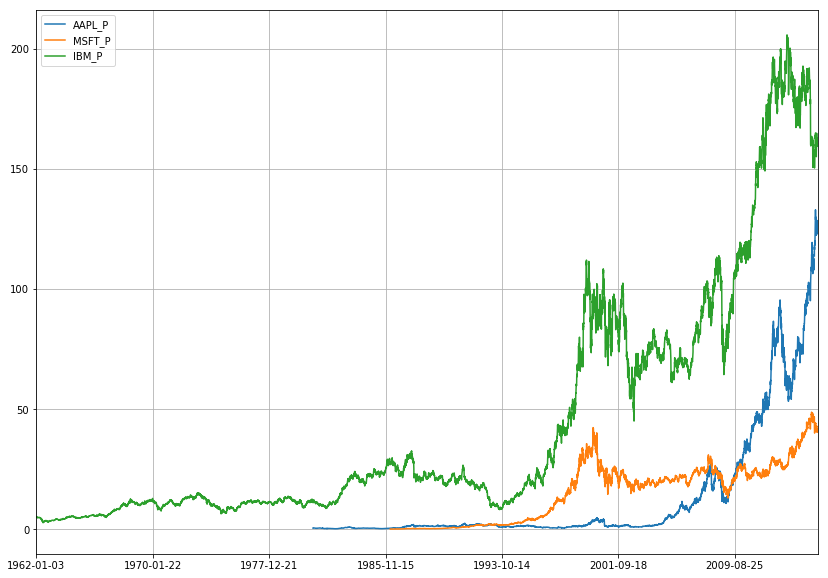

In [10]:
# plot some stocks
Diffs[['AAPL_P','MSFT_P','IBM_P']].plot(figsize=(14,10));
plt.grid()

Lastly,we now save *Diffs* as a csv

In [ ]:
Diffs.to_csv('SP500.csv')